# Thesis work--2
# A new method for multivariate regression problem for improving fitness in Genetic Programming

### Importing the libraries

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randrange, uniform
from sklearn.utils import check_random_state
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from gplearn.genetic import SymbolicRegressor
from matplotlib.pyplot import figure

### Global variables and functions for tuning

In [2]:
FEATURES = 2
NUMBER_OF_GENERATION = 20
ROWS = 300
POPULATION_SIZE = 400
TEST_SIZE = .2
NUMBER_OF_REGIONS = 3
formula = lambda X: X[:, 0]**2 - X[:, 1]**2 + X[:, 1] - 1

### Generating Training Samples

In [4]:
rng = check_random_state(0)
X = rng.uniform(-1, 1, ROWS).reshape(ROWS//FEATURES, FEATURES)
Y = formula(X)

### Splitting the dataset into the Training set and Test set

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

### Applying PCA

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 1)
#print(X_train)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
#print(X_train_pca)
#print(X_test_pca)
# print(np.shape(X_train),np.shape(X_test))
#print(explained_variance)

### Calculating DV

In [7]:
# sort X_train_pca and y_train by index
sorted_indexes = np.argsort(X_train_pca,axis=0)
sorted_x_train_pca = X_train_pca[sorted_indexes]
sorted_y_train = y_train[sorted_indexes]

# Finding Change of Slope
slope1 = []
slope2 = []
for itr in range(1,len(sorted_x_train_pca)):
    slope1.append((sorted_y_train[itr]-sorted_y_train[itr-1])/(sorted_x_train_pca[itr]-sorted_x_train_pca[itr-1]))
for itr in range(1,len(slope1)):
    slope2.append((slope1[itr]-slope1[itr-1])/(sorted_x_train_pca[itr]-sorted_x_train_pca[itr-1]))

# normalize slope2 
normalized_slope2 = (slope2-min(slope2))/(max(slope2)-min(slope2))

# Calculating Quantiles
normalized_slope2 = np.reshape(normalized_slope2,len(normalized_slope2))
quantile_ranges = pd.qcut(normalized_slope2,NUMBER_OF_REGIONS,labels=False,retbins=True)
quantile_ranges = quantile_ranges[1]

# Adding the difficult Vectors
difficult_points = {}
for q_ind in range(NUMBER_OF_REGIONS):
    low = quantile_ranges[q_ind]
    high = quantile_ranges[q_ind+1]
    difficult_points[q_ind] = []
    for n_ind in range(0,len(normalized_slope2)):
        if normalized_slope2[n_ind] >= low and normalized_slope2[n_ind] <= high:
            difficult_points[q_ind].append(n_ind)
print(difficult_points)

{0: [2, 3, 7, 10, 12, 14, 19, 22, 24, 25, 29, 31, 33, 35, 37, 41, 44, 49, 51, 53, 54, 56, 62, 64, 67, 72, 74, 78, 79, 82, 84, 86, 90, 94, 97, 99, 101, 103, 110, 113], 1: [0, 1, 5, 9, 11, 17, 18, 27, 36, 40, 46, 47, 48, 58, 59, 60, 65, 66, 69, 70, 75, 76, 79, 81, 87, 88, 89, 91, 92, 95, 98, 105, 106, 107, 108, 111, 114, 115, 116, 117], 2: [4, 6, 8, 11, 13, 15, 16, 20, 21, 23, 26, 28, 30, 32, 34, 38, 39, 42, 43, 45, 50, 52, 55, 57, 61, 63, 68, 71, 73, 77, 80, 83, 85, 93, 96, 100, 102, 104, 109, 112]}


### Training of converted PCA

In [8]:
est_gp = SymbolicRegressor(population_size=POPULATION_SIZE,
                           generations=NUMBER_OF_GENERATION, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)


### Getting the different regions of difficulty level

In [9]:
# Hard to evolve points
hard_to_evolve_x = X_train_pca[difficult_points[0]]
hard_to_evolve_y = y_train[difficult_points[0]]

# Medium to evolve points
medium_to_evolve_x = X_train_pca[difficult_points[1]]
medium_to_evolve_y = y_train[difficult_points[1]]

# Easy to evolve points
easy_to_evolve_x = X_train_pca[difficult_points[2]]
easy_to_evolve_y = y_train[difficult_points[2]]


### Feed the system hard to evolve points first

In [10]:
est_gp.fit(hard_to_evolve_x,hard_to_evolve_y)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    46.62 81.35580984963467       15 0.5226602104681045 0.18657394344567546      9.29s
   1    11.84 2.370129450981327        7 0.40371018765547817 0.5651704149650335     11.54s
   2      8.9 1.135546949227627        7 0.38387045665789415 0.7437279939432903     11.41s
   3     7.56 1.0849293438962144        7 0.33174376492399565 1.2128682195483762     10.91s
   4     7.03 1.0194092229457348        7 0.36454508913297823 0.9176563016675334     10.74s
   5     6.76 1.0210115269863218        7 0.36391414122224686 0.7162377017055817     10.29s
   6     6.55 1.1694955588406741        7 0.33913845243411234 0.9214245184627423      9.31s
   7     6.42 1.450040287899351        7 0.3461359284671352 0.8584472341655367      8.56s
   8     5.98 1.10015337

### Feed the system Medium to evolve points keeping the current modal state appending generation by current generation

In [11]:
est_gp.set_params(generations=NUMBER_OF_GENERATION*2, warm_start=True)
est_gp.fit(medium_to_evolve_x,medium_to_evolve_y)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  20     5.13 0.8574487518602965        5 0.3267866271029777 0.8472058383183463      0.57s
  21     5.42 1.0934804262498263        5 0.3341710163619804 0.7807463349873226      0.98s
  22     5.54 1.3065910550360171        5 0.3219719956373253 0.8905375215092179      1.21s
  23     5.22 0.9163133307088017        5 0.3360238074178759 0.764071215484263      1.53s
  24     5.25 1.3271196762143518        5 0.32890460293792345 0.8281440558038344      1.79s
  25     5.06 0.9318812346741475        5 0.325343980224737 0.8601896602225131      1.86s
  26      5.2 1.1513096595670227        5 0.32391126236464934 0.8730841209633019      1.96s
  27     5.32 0.9750074593918298        5 0.33102674647804403 0.8090447639427496      1.93s
  28     5.39 1.1859917523

### Same process but for easy to evolve points and this is our result

In [12]:
est_gp.set_params(generations=NUMBER_OF_GENERATION*3, warm_start=True)
est_gp.fit(easy_to_evolve_x,easy_to_evolve_y)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  40     5.56 1.3826835874818966        5 0.4267099561006126 1.0382196834949988      0.25s
  41     5.65 1.1283526081175839        5 0.43380834472817964 0.9743341858468948      0.42s
  42     5.15 1.2982424272198967        7 0.3586519772549437 0.4676661152019958      0.60s
  43     5.38 2.313528759890423        7 0.3574685028562641 0.47831738479011243      0.74s
  44     6.04 0.9380894201342194        7 0.32200319197302285 0.797505182739283      0.89s
  45     7.34 1.0247895655139905        7 0.322909960559394 0.7893442654619429      1.02s
  46      7.4 1.2534829078501897        7 0.30928489334209175 0.9119698704176632      1.15s
  47     7.42 2.6615992258033248        7 0.3357815941608486 0.6734995630488516      1.32s
  48     7.02 1.4091321896

### Training of data without PCA without DV

In [13]:
# Generating random data
rng = check_random_state(0)
X = rng.uniform(-1, 1, ROWS).reshape(ROWS//FEATURES, FEATURES)
Y = formula(X)
# Dividing it into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = TEST_SIZE, random_state = 0)
# Training the system
est_gp = SymbolicRegressor(population_size=POPULATION_SIZE,
                           generations=NUMBER_OF_GENERATION*3, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train,y_train)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    37.62 3240.640395038094        7 0.6545326193170877 0.6616696381861505     27.60s
   1     10.7 92.47048856168368       33 0.4709350621474633 0.2862887087816357     43.32s
   2     8.14 1.273082989831628        9 0.3569102194188221 0.3925020603803262     41.52s
   3     5.94 0.9222795634594203        9 0.28938466071396307 0.22662414357543156     44.05s
   4     7.12 0.9018641283795599        9 0.27050030819879933 0.39658331621190523     42.21s
   5      7.2 1.4341901879856875       13 0.2544773141806192 0.42613402596172145     42.16s
   6     8.99 1.2355242305923293        9 0.253047676152755 0.5536570046263042     40.91s
   7     9.06 0.7637524505958402       11 0.2545534634939961 0.3196812755892966     40.15s
   8     9.14 0.7732535419

### Calculate fitness 

In [14]:
x0 = X_test[:,0]
x1 = X_test[:,1]
predicted_formula_result_y = est_gp.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
fitness = mean_squared_error(y_test, predicted_formula_result_y)
print('Fitness of Training of data without PCA without DV: ',str(fitness))

Fitness of Training of data without PCA without DV:  0.1583493614822914


### Training of data with PCA without DV

In [15]:
# Generating random data
rng = check_random_state(0)
X = rng.uniform(-1, 1, ROWS).reshape(ROWS//FEATURES, FEATURES)
Y = formula(X)

# Dividing it into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = TEST_SIZE, random_state = 0)

# Convert it to PCA
pca = PCA(n_components = 1)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Training the system
est_gp = SymbolicRegressor(population_size=POPULATION_SIZE,
                           generations=NUMBER_OF_GENERATION*3, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train_pca,y_train)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    46.62  73.561646844872       15 0.45794064423252584 0.5832914875042755     37.30s
   1    12.11 2.2732534282980037        7 0.37893692918293836 0.5132012503244892     44.49s
   2      8.2 1.199192283177446        7 0.37817371139549316 0.5200702104114959     43.38s
   3     6.06 0.9396369646395795        7 0.38028213399020167 0.42934383959468914     40.62s
   4     5.74 0.9382336536739111        7 0.3675312186046419 0.6158526455291579     38.79s
   5     7.14 0.9837011059871148        7 0.3669262113467895 0.621297710849829     38.90s
   6     7.04 1.1911653009775511        7 0.35647760357587505 0.7153351807880591     38.34s
   7     7.15 1.3965400296965695        7 0.36429674944117313 0.6449628680003767     38.20s
   8      7.2 1.21795504

### Calculate Fitness

In [16]:
x0 = X_test[:,0]
x1 = X_test[:,1]
predicted_formula_result_y = est_gp.predict(np.c_[x0.ravel()]).reshape(x0.shape)
fitness = mean_squared_error(y_test, predicted_formula_result_y)
print('Training of data with PCA without DV: '+str(fitness))

Training of data with PCA without DV: 1.6208536829478182


### Training of data with PCA with DV

In [55]:
def train_pca_dv(seed_value):
    # Generating random data
    rng = check_random_state(seed_value)
    X = rng.uniform(-1, 1, ROWS).reshape(ROWS//FEATURES, FEATURES)
    Y = formula(X)

    # Dividing it into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = TEST_SIZE, random_state = 0)
    list_of_x_test.append(X_test)
    list_of_y_test.append(y_test)
    # Convert it to PCA
    pca = PCA(n_components = 1)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Applying DV
    # sort X_train_pca and y_train by index
    sorted_indexes = np.argsort(X_train_pca,axis=0)
    sorted_x_train_pca = X_train_pca[sorted_indexes]
    sorted_y_train = y_train[sorted_indexes]

    # Finding Change of Slope
    slope1 = []
    slope2 = []
    for itr in range(1,len(sorted_x_train_pca)):
        slope1.append((sorted_y_train[itr]-sorted_y_train[itr-1])/(sorted_x_train_pca[itr]-sorted_x_train_pca[itr-1]))
    for itr in range(1,len(slope1)):
        slope2.append((slope1[itr]-slope1[itr-1])/(sorted_x_train_pca[itr]-sorted_x_train_pca[itr-1]))

    # normalize slope2 
    normalized_slope2 = (slope2-min(slope2))/(max(slope2)-min(slope2))

    # Calculating Quantiles
    normalized_slope2 = np.reshape(normalized_slope2,len(normalized_slope2))
    quantile_ranges = pd.qcut(normalized_slope2,NUMBER_OF_REGIONS,labels=False,retbins=True)
    quantile_ranges = quantile_ranges[1]

    # Adding the difficult Vectors
    difficult_points = {}
    for q_ind in range(NUMBER_OF_REGIONS):
        low = quantile_ranges[q_ind]
        high = quantile_ranges[q_ind+1]
        difficult_points[q_ind] = []
        for n_ind in range(0,len(normalized_slope2)):
            if normalized_slope2[n_ind] >= low and normalized_slope2[n_ind] <= high:
                difficult_points[q_ind].append(n_ind)
    # Hard to evolve points
    hard_to_evolve_x = X_train_pca[difficult_points[0]]
    hard_to_evolve_y = y_train[difficult_points[0]]

    # Medium to evolve points
    medium_to_evolve_x = X_train_pca[difficult_points[1]]
    medium_to_evolve_y = y_train[difficult_points[1]]

    # Easy to evolve points
    easy_to_evolve_x = X_train_pca[difficult_points[2]]
    easy_to_evolve_y = y_train[difficult_points[2]]

    # Training the system
    est_gp = SymbolicRegressor(population_size=POPULATION_SIZE,
                               generations=NUMBER_OF_GENERATION, stopping_criteria=0.01,
                               p_crossover=0.7, p_subtree_mutation=0.1,
                               p_hoist_mutation=0.05, p_point_mutation=0.1,
                               max_samples=0.9, verbose=1,
                               parsimony_coefficient=0.01, 
                               random_state=0, 
                               init_depth=(2,17)
                              )
    est_gp.fit(hard_to_evolve_x,hard_to_evolve_y)
#     print(est_gp._program)
    est_gp.set_params(generations=NUMBER_OF_GENERATION*2, warm_start=True)
    est_gp.fit(medium_to_evolve_x,medium_to_evolve_y)
#     print(est_gp._program)
    est_gp.set_params(generations=NUMBER_OF_GENERATION*3, warm_start=True)
    est_gp.fit(easy_to_evolve_x,easy_to_evolve_y)
    print(est_gp._program)
    list_of_est_program.append(str(est_gp._program))
    x0 = X_test[:,0]
    x1 = X_test[:,1]
    predicted_formula_result_y = est_gp.predict(np.c_[x0.ravel()]).reshape(x0.shape)
    fitness = mean_squared_error(y_test, predicted_formula_result_y)
    print('Training of data with PCA with DV: '+str(fitness))
    list_of_fitness.append(str(fitness))

In [56]:
list_of_fitness = []
list_of_est_program = []
list_of_x_test = []
list_of_y_test = []
for itr in range(0,20):
    print('Run :',itr+1)
    train_pca_dv(itr) 

Run : 1
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0  34438.9 1.1207478835364914e+56        7 0.6415020848222629 0.8565181100260962     74.04m
   1    20.46 1.9791146456120372        7 0.4516293623188091 0.5385158797199848     35.94m
   2      8.3 1.5232141056159176        5 0.38509015737798596 0.7548553836238179     22.95m
   3     7.24 8.50713673663683       11 0.3443478711539696 0.9108005944479538     16.67m
   4     5.85 1.2343594113532774       11 0.3834076910299042 0.5592622155645431     12.65m
   5     6.06 3.9579073733524943        5 0.355481330777238 1.02133482303055     10.02m
   6      5.3 1.7054419961940102        5 0.3572065149295345 1.0058081656598816      8.24m
   7     5.39 4.069511418643701        5 0.364536872022341 0.9398349518246225      6.82m
   8     6.16 1.07989

  19      1.7 19.193045555117227        1 0.3597325428646895 1.0496613126830856      0.00s
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  20     1.56 0.556563287072702        1 0.3712311903496276 1.4749293265583898      4.55s
  21     2.88 3.6060176015416867        1 0.40582289872218547 1.1636039512053689     15.59s
  22     2.54 9.111250863619206        1 0.40359239872289276 1.1836784511990033     19.72s
  23     1.42 0.5875884115968358        1 0.3867089521208598 1.3356294706172993     22.59s
  24     1.54 1.0242656821036888        1 0.40974635699349776 1.128292826763558     23.62s
  25     2.45 305316.06966201076        1 0.3801131151233208 1.3949920035951506     24.26s
  26     2.18 1.5786804482141477        1 0.3878344616021539 1.3254998852856528     25.69s
  27     1.54 0.71123640708

  38     4.76 1.2547428053785659        3 0.3043187743022173 0.8405221566687102      3.54s
  39     3.46 1.2352826421502738        3 0.29711398907426506 0.7050733343639235      0.00s
    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  40     4.28 0.8666327623606555        3 0.4205480231797404 0.8048573408963697      3.90s
  41     3.71 1.0091967007158442        3 0.41066813522863876 0.8937763324562845      7.62s
  42     3.47 0.726554631379158        3 0.417778243546947 0.8297853575915108     10.23s
  43     3.24 0.7580706135481943        3 0.4160918591182095 0.8449628174501478     11.29s
  44     3.72 2.442480460707094        5 0.39402911525506007 0.45520530690977357     12.35s
  45     3.53 0.7621783380024604        5 0.35184173780910677 0.8348917039233527     13.20s
  46     4.26 0.988263127

KeyboardInterrupt: 

In [51]:
print('Predicted functions of ' +str(len(list_of_est_program)) +' Runs with tree depth (2,17)')
for ind in range(0,len(list_of_est_program)):
    print('Function '+str(ind)+' '+list_of_est_program[ind])

Predicted functions of 20 Runs with tree depth (2,17)
Function 0 add(-0.848, sub(X0, mul(X0, X0)))
Function 1 -0.723
Function 2 add(-0.993, add(X0, -0.197))
Function 3 add(-0.974, X0)
Function 4 -0.824
Function 5 add(X0, -0.974)
Function 6 -0.765
Function 7 add(-0.922, add(X0, -0.232))
Function 8 -0.823
Function 9 sub(-0.911, X0)
Function 10 add(-0.993, X0)
Function 11 add(-0.922, X0)
Function 12 sub(-0.986, X0)
Function 13 -0.823
Function 14 sub(X0, sub(0.888, -0.335))
Function 15 sub(-0.985, X0)
Function 16 sub(-0.902, X0)
Function 17 add(-0.922, X0)
Function 18 -0.697
Function 19 add(X0, -0.974)


In [38]:
print('Predicted functions of ' +str(len(list_of_est_program)) +' Runs with tree depth (6,10)')
for ind in range(0,len(list_of_est_program)):
    print('Function '+str(ind)+' '+list_of_est_program[ind])

Predicted functions of 20 Runs with tree depth (6,10)
Function 0 sub(sub(X0, 0.778), mul(X0, X0))
Function 1 -0.801
Function 2 sub(X0, div(-0.957, -0.885))
Function 3 sub(sub(X0, 0.778), mul(X0, X0))
Function 4 -0.871
Function 5 sub(X0, div(X0, X0))
Function 6 -0.781
Function 7 sub(X0, sub(0.699, -0.444))
Function 8 sub(mul(X0, -0.458), 0.898)
Function 9 sub(-0.986, X0)
Function 10 sub(X0, 0.991)
Function 11 sub(X0, 0.902)
Function 12 sub(sub(0.081, X0), div(0.278, 0.231))
Function 13 -0.926
Function 14 sub(X0, add(0.729, 0.341))
Function 15 -0.785
Function 16 sub(mul(X0, 0.224), sub(X0, -0.947))
Function 17 add(-0.974, X0)
Function 18 -0.769
Function 19 add(-0.929, X0)


In [19]:
print('Predicted functions of ' +str(len(list_of_est_program)) +' Runs with tree depth (2,6)')
for ind in range(0,len(list_of_est_program)):
    print('Function '+str(ind)+' '+list_of_est_program[ind]+' With fitness '+' '+list_of_fitness[ind])

Predicted functions of 20 Runs with tree depth (2,6)
Function 0 sub(-0.749, sub(mul(X0, X0), X0)) With fitness  1.5464592643832455
Function 1 -0.713 With fitness  0.5755026098148425
Function 2 add(sub(X0, 0.159), -0.965) With fitness  0.9643061484795903
Function 3 sub(add(-0.834, X0), mul(X0, X0)) With fitness  1.1616546820083762
Function 4 -0.803 With fitness  0.6143737679833474
Function 5 sub(-0.931, mul(X0, -0.606)) With fitness  0.7717159012760556
Function 6 -0.765 With fitness  0.5277935220732879
Function 7 sub(sub(X0, 0.159), 0.971) With fitness  0.9920810334216495
Function 8 -0.931 With fitness  0.3008120488937444
Function 9 sub(-0.931, X0) With fitness  0.9781697851795068
Function 10 add(-0.986, X0) With fitness  0.4434641396982191
Function 11 sub(sub(X0, 0.834), mul(X0, X0)) With fitness  1.2510682270227254
Function 12 sub(sub(-0.440, X0), 0.671) With fitness  0.6388961110948697
Function 13 -0.749 With fitness  0.8471336680119064
Function 14 sub(sub(X0, 0.159), 0.946) With fit

### Calculate fitness

In [47]:
# add(-0.993, add(X0, -0.197))
x0 = X_test[:,0]
x1 = X_test[:,1]
predicted_formula_result_y = -.993+(x0-.197)
# predicted_formula_result_y = (x0-.877)-(x0*x0)
fitness = mean_squared_error(y_test, predicted_formula_result_y)
print('Training of data with PCA with DV: '+str(fitness))

Training of data with PCA with DV: 1.2656720723586143


# Visulaiztions

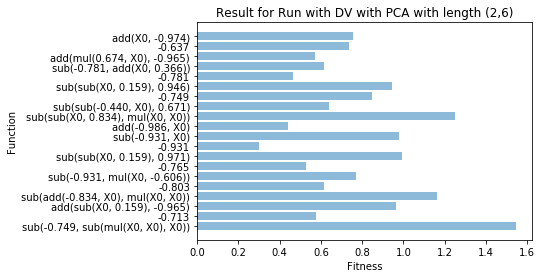

In [51]:
# Round the fitness to 3 decimal points for easy visualizaiton
list_of_rounded_fitness = []
for fitness in list_of_fitness:
    list_of_rounded_fitness.append(round(float(fitness),3))
objects = list_of_est_program
y_pos = np.arange(len(objects))
performance = list_of_rounded_fitness
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.ylabel('Function')
plt.xlabel('Fitness')
plt.title('Result for Run with DV with PCA with length (2,6)')
 
plt.show()

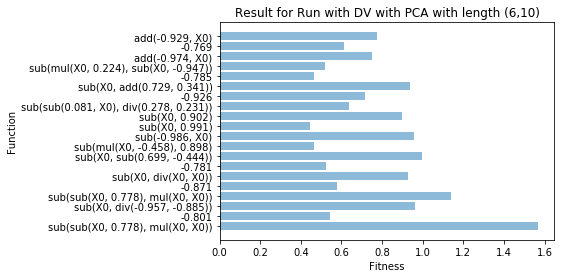

In [54]:
# Round the fitness to 3 decimal points for easy visualizaiton
list_of_rounded_fitness = []
for fitness in list_of_fitness:
    list_of_rounded_fitness.append(round(float(fitness),3))
objects = list_of_est_program
y_pos = np.arange(len(objects))
performance = list_of_rounded_fitness
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.ylabel('Function')
plt.xlabel('Fitness')
plt.title('Result for Run with DV with PCA with length (6,10)')
 
plt.show()

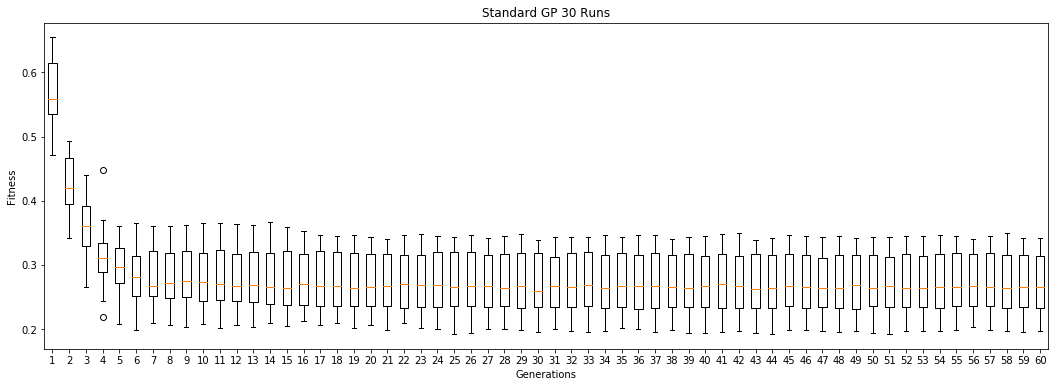

In [50]:
data = [[0.6545326193170877, 0.5034866507175532, 0.5916314599867414, 0.5456890496964114, 0.541132384843471, 0.5190096831410683, 0.5299072775748193, 0.5988122957875482, 0.5381812420337135, 0.5496788202250519, 0.6204318132830378, 0.5269853650536719, 0.6245698402338328, 0.5737775275298912, 0.6116779598185913, 0.5571421752647843, 0.6198924910900514, 0.6448423991551425, 0.503768250858107, 0.5942428731882591, 0.47125502519728135, 0.6165925252273311, 0.5700836336354455, 0.5597170144902269, 0.6492222132845684, 0.535156179228019, 0.6355300598662423, 0.49459937767247897, 0.5369713639415012, 0.5417572433082436], [0.4709350621474633, 0.4354270502971246, 0.4257583802618658, 0.3441158638793553, 0.493701714724974, 0.48199468834746284, 0.39458997273105906, 0.36721127290426686, 0.3752003955423844, 0.4805855734570671, 0.3949583001242018, 0.45147977129226136, 0.36651390435855186, 0.4084334973913348, 0.37420342733338363, 0.4673439138359971, 0.39435411210895194, 0.4091018430459062, 0.4871281515671441, 0.346430339504461, 0.4195683717749175, 0.40763114844531634, 0.44318603411596913, 0.4023624374299305, 0.4659269064000482, 0.34262136339313726, 0.43256134478399844, 0.42063740376632325, 0.47747108341626615, 0.47919684721328637], [0.3569102194188221, 0.4305657795750091, 0.37435694604201025, 0.26542844842453034, 0.3300994468679229, 0.32971079592922065, 0.3258866851468396, 0.3434100045048439, 0.36361453090347157, 0.3170196493739827, 0.3745726819708383, 0.42624953355266054, 0.2983817322247329, 0.37911696712743564, 0.33485919474240133, 0.44009598059938715, 0.3937411916821058, 0.40967587204966144, 0.42263960025427877, 0.3376514972065905, 0.31715673658620364, 0.3848926683543186, 0.34944636118477396, 0.3866207858152781, 0.3801903496646374, 0.2985977328964187, 0.4052336014337566, 0.3078891094926553, 0.4303786723687957, 0.3367086110369278], [0.28938466071396307, 0.27835777481601026, 0.31400487921109455, 0.26335053729725155, 0.3107178229501057, 0.33259549524653403, 0.2943285185091668, 0.3352073620933532, 0.2752388050308395, 0.2948395029928061, 0.36568417960729743, 0.2772289561033652, 0.28955068603051637, 0.3524482427287782, 0.2187351623834963, 0.31922760613364143, 0.44824350466870666, 0.32907873307753455, 0.369985785798708, 0.27472773584117977, 0.3104516588827726, 0.2978647396193434, 0.321229485735932, 0.3706884325168217, 0.3635825595476124, 0.2903212262478168, 0.24410788823039697, 0.30807584911033364, 0.3354101123141607, 0.3210819026068323], [0.27050030819879933, 0.27709463310763827, 0.3108640284183553, 0.24787690256164896, 0.29986368724100965, 0.32830646052906376, 0.2762325540900037, 0.3399819360679015, 0.26543594355126293, 0.25694974168123125, 0.3603442816471013, 0.28765508315965466, 0.28229638303488824, 0.348196760290412, 0.20823254011016548, 0.3033752858034702, 0.3087504406824817, 0.322216165450462, 0.3507294872579796, 0.2579233241258836, 0.29988897518982527, 0.2855240284148569, 0.31933405052928404, 0.3425230212841694, 0.3580826208773483, 0.2824598454299701, 0.23886263479064418, 0.2936147983901836, 0.3290665673694485, 0.26466441048100575], [0.2544773141806192, 0.2670564207002866, 0.2952714991434368, 0.24314300317602217, 0.30698431939474213, 0.3169043705007984, 0.24108268297056779, 0.3384056009275319, 0.2509169696135504, 0.25045967254374507, 0.3649751718591601, 0.27033852788646434, 0.2631039191419904, 0.3269583910934615, 0.198963679794814, 0.2615343460884802, 0.2970772685976801, 0.28289083643763274, 0.3422688106052018, 0.23867281954402092, 0.30064308101483583, 0.279805541816906, 0.31707446995236865, 0.33917973150101915, 0.3498943987860318, 0.274569107943969, 0.23556563753866527, 0.30152597753434296, 0.2886339705180252, 0.25123461269197883], [0.253047676152755, 0.26379827823456664, 0.2997661204253284, 0.24047796576752908, 0.30972647867080566, 0.320940134052189, 0.23717079814605496, 0.34101428521977756, 0.25358778132434906, 0.2459402805015969, 0.3603832825606378, 0.24730312377918504, 0.2632361513808111, 0.3239664015343551, 0.20921078367816456, 0.2589773684457137, 0.25809579945737565, 0.3280764079456332, 0.3349722408412336, 0.24861626100987386, 0.2967890630863187, 0.2792724208959889, 0.3209346337668751, 0.3467507257765242, 0.34859965365145706, 0.27005119212500533, 0.2310136583959591, 0.290335878149909, 0.2626111047525372, 0.25028554781571255], [0.2545534634939961, 0.2638178456219223, 0.296289857020843, 0.23980085066579035, 0.3116840508967733, 0.3190150590222366, 0.23455110886291525, 0.3363965760910521, 0.2485321756793305, 0.244936635656685, 0.3586964306782817, 0.2719590055643523, 0.27212357513791274, 0.3270674964152446, 0.20687778535710596, 0.2537105321045634, 0.24967333838451125, 0.3306611646444764, 0.3354146074547461, 0.24277995548249004, 0.2907693357453958, 0.27691304559925023, 0.3167325898181482, 0.3605296314024255, 0.3450339996488434, 0.270857322418888, 0.23260505284606398, 0.30127023697595867, 0.2587191092933291, 0.2454992699595558], [0.2578874746694214, 0.26688495636137133, 0.29834224053051367, 0.2411390441306727, 0.3099936903017983, 0.3229114376499683, 0.23052814683886544, 0.33519069307288374, 0.24905698560680414, 0.24504561957496604, 0.362321352181057, 0.3190251601458573, 0.2580534239691798, 0.32513893366789204, 0.20385606732909484, 0.24993725390729904, 0.2538120755042175, 0.32778194663491395, 0.33380843313535946, 0.2406954332328444, 0.288042357399689, 0.2778516325223064, 0.31180095553966714, 0.3628786349436254, 0.3378308294455126, 0.270479251547093, 0.23315456907307042, 0.29770780131022945, 0.25537602991379427, 0.24578844965217636], [0.25103982172368233, 0.26618731337276913, 0.3018248030740849, 0.24157207283536616, 0.30682263813484895, 0.3181808801752562, 0.22594845258805962, 0.3428635377922137, 0.24536229769608975, 0.24114467147308946, 0.35984413435843715, 0.3193926245902368, 0.2437355120361754, 0.32684015846392817, 0.20740890181671573, 0.24688866679069277, 0.250775557388165, 0.3306019231995678, 0.33696559661586806, 0.2433401999191295, 0.2954011794425725, 0.2780393719889797, 0.31824923079975215, 0.36456212833894874, 0.3435542687837271, 0.2675323748450654, 0.23158161269090158, 0.2991158145048731, 0.2538854311117958, 0.2435828412115988], [0.25074529390902633, 0.26367201530601164, 0.3039613624433382, 0.2383619073357982, 0.31014851635452095, 0.3232422223606752, 0.22708152113897662, 0.33872053589615014, 0.24649455326215144, 0.24446854448676875, 0.35757073339322193, 0.3217827092386027, 0.2402470042275222, 0.3283607494118782, 0.2013625213045456, 0.24999854178901332, 0.24562631513797464, 0.3247905245216669, 0.33626999384090855, 0.23626940509076697, 0.2993766513249635, 0.2779247664496974, 0.3167423767637839, 0.36529569661605343, 0.3461450347034325, 0.25722202376626185, 0.22951338148315184, 0.30317708357105516, 0.254328322860415, 0.24659066811207964], [0.2501265945882167, 0.2584739410401094, 0.29703765741668575, 0.2396755757880527, 0.3029867553493616, 0.30702376050784436, 0.23513695323731343, 0.3382778735139175, 0.2474188910911499, 0.24169070245119584, 0.36331134321277714, 0.3183973639484263, 0.24165378849662159, 0.32639303443904355, 0.20648700765521, 0.2493706140590279, 0.2502915842092933, 0.3293056813898507, 0.3358110605709249, 0.2346858009396088, 0.2931328194994239, 0.27642749709344694, 0.3154378117131625, 0.3588094086181482, 0.3432870642926388, 0.24141950613392987, 0.23394652619863857, 0.30009603996498996, 0.25256726676998725, 0.24838336077618361], [0.24845038728996147, 0.260146780884736, 0.29868815860169495, 0.23566756876165287, 0.3042069690177169, 0.32041135559409717, 0.2284494368418784, 0.3380263586984705, 0.24851711375160532, 0.24186563349973844, 0.36114761068196277, 0.3194146463575161, 0.23642629002670254, 0.32283685423015623, 0.20345284182827394, 0.25072492276872366, 0.2507363889640797, 0.329419791735573, 0.33807969120991815, 0.22974347818341376, 0.29921480789652777, 0.278731903800701, 0.3147706346771464, 0.36270701826659074, 0.3433539614888299, 0.23989477426241612, 0.23718394515833965, 0.29928537381713877, 0.2543326340128697, 0.24527920906694742], [0.25319904387689196, 0.2528134457222099, 0.30022566421340147, 0.22517340914748338, 0.30689271523086387, 0.3129804603215592, 0.22997635644183384, 0.3335995788527142, 0.24406061596917705, 0.23859242536589972, 0.36629021737336437, 0.31003625198844353, 0.23592026385934417, 0.32700376970687767, 0.20899375159075295, 0.24099842419608727, 0.25206731430468593, 0.3259751895333305, 0.33540291808009953, 0.2274302075181157, 0.29533738805380505, 0.2768541268990479, 0.31959328123315484, 0.36665935883091677, 0.3395482116108244, 0.2339453017849172, 0.23740841591341225, 0.2978062378327465, 0.24709218202081665, 0.24743269675526264], [0.25322542322292335, 0.2593682867939463, 0.3004673613888208, 0.2192667905973465, 0.311857742313786, 0.31719121921411647, 0.22949876532485303, 0.33926186834889205, 0.24626992468006445, 0.22897762639347571, 0.358616564650232, 0.3144190390859795, 0.22817711076136749, 0.32810184249829005, 0.20550590084816095, 0.245568769789492, 0.25010025381136036, 0.3301746026828814, 0.33390128048878537, 0.22641094998669764, 0.29969805546778416, 0.2699047804592009, 0.322891344660374, 0.35892134965428313, 0.33990149270274983, 0.22779909317418684, 0.2348390321379956, 0.30033218523435323, 0.24498603997715412, 0.24885558262373117], [0.2545292694952185, 0.26362568757277005, 0.29912931030312434, 0.21356190073201867, 0.30915035811763203, 0.3175601733142099, 0.22828462035301397, 0.33370024390031694, 0.24191985031507304, 0.22544709963666795, 0.3528814760786325, 0.31474906927545804, 0.22873631880772297, 0.32874349359989774, 0.21225847890212343, 0.24464662971482423, 0.2476520990546134, 0.3296676443560571, 0.334304508617167, 0.22993158314991038, 0.2968657966335694, 0.2754313244189594, 0.3076297331979549, 0.350375339678999, 0.3440689479511572, 0.22242635294684981, 0.23596351532975182, 0.2956053204887826, 0.24488626301745348, 0.2472091535935711], [0.2496610258604738, 0.2626572211645827, 0.295882224444205, 0.21272809374565615, 0.310181649954254, 0.3196715814063031, 0.23244874812338556, 0.32597715487092976, 0.23983036528648735, 0.21699842840006353, 0.3456858644276651, 0.322287020442414, 0.2288432240598528, 0.3267905126089407, 0.20653191674389806, 0.2451955737394639, 0.2450768150095546, 0.32694383456087345, 0.33058802575529966, 0.22969846715536907, 0.29894369794044817, 0.2714951579631, 0.318777642316381, 0.3460013298691137, 0.3439465397136672, 0.22802286007963649, 0.23545964189439997, 0.29250448920870664, 0.24052798571884643, 0.24848285356567154], [0.2539795564501502, 0.25821126576291104, 0.30153245564813386, 0.20963014354977552, 0.3044046779137584, 0.320254094900415, 0.230851149276207, 0.32234477868512007, 0.23859005003529385, 0.22039407386031276, 0.3445039908544058, 0.31477160437073703, 0.22821882024848375, 0.3268203818906732, 0.21091723042711547, 0.24243855687333785, 0.2415512465903605, 0.32797361039097445, 0.3373790636010841, 0.2244712817775026, 0.29678710168885264, 0.27719512155006376, 0.31976240158330244, 0.34141682655121336, 0.3389546619465091, 0.22259363715312533, 0.23499307289390897, 0.3011938657259482, 0.2417974286361909, 0.2493573374346655], [0.2553369114067439, 0.25901054835000203, 0.302462360844245, 0.20972044059282985, 0.30025375332696036, 0.3165837181959092, 0.23422874345071218, 0.32862521215617757, 0.23993766631857566, 0.22070676992643515, 0.33799526283917297, 0.3174438545668825, 0.23144850563978647, 0.32735445664742774, 0.20225483172363187, 0.23953118661783765, 0.24158842775650596, 0.32473449313300196, 0.334106739547175, 0.22707566869573906, 0.30040153576119877, 0.2694354245411004, 0.3195823977224065, 0.34339211646637235, 0.34713101917989814, 0.22475064690516539, 0.23771553377459081, 0.300061460056271, 0.23536854384521153, 0.2481915120348161], [0.25666424944735555, 0.26273688184560007, 0.3017340069983251, 0.2138336153025165, 0.3090545343112516, 0.31711341243777486, 0.23033015527178494, 0.31916056285817257, 0.239160121791487, 0.21958533906149308, 0.3437751449850588, 0.3105066178354296, 0.23426230682845475, 0.32611522122178715, 0.2066154855790177, 0.2389748690718045, 0.24168243544078327, 0.3310860903599412, 0.33700494496927813, 0.22162029375845402, 0.30316304562094804, 0.2696878186280347, 0.31575534969943453, 0.3408180000339987, 0.334650442093924, 0.22191703782150166, 0.2323040397313589, 0.28891707088233964, 0.2436648829001569, 0.24687029957253154], [0.24465336892327116, 0.2599260276092084, 0.28950300301819865, 0.2124278401335187, 0.31186310251849897, 0.31823080881916727, 0.23140787077792394, 0.32520193326148794, 0.23675688709044784, 0.22051191305561263, 0.3409291483295572, 0.31640260906724854, 0.22212464216055428, 0.32827262226109283, 0.1986244194408741, 0.24158558919666312, 0.2456627500733547, 0.32572346628717846, 0.32526921248772606, 0.22835701659636184, 0.2963868569747127, 0.27492608159098036, 0.31438257732116004, 0.3390610544751479, 0.340921813520985, 0.2268377801290129, 0.23549474131863427, 0.29854883687577494, 0.24398436994519826, 0.2491395702282532], [0.24608158295889404, 0.2618513520131897, 0.29938460621993285, 0.21429287095068034, 0.3112253047824325, 0.3157415395165883, 0.22911445003411027, 0.3160650995073477, 0.23698691546861508, 0.22149273884072931, 0.3433249400235607, 0.31473872548722936, 0.23061929541764242, 0.3270969837041299, 0.20977225954156406, 0.23483602344657525, 0.23960392372449169, 0.3269170257754743, 0.33514917819494827, 0.2310317488555661, 0.29470981225332576, 0.2778385045268576, 0.3225552236783524, 0.3361749031339872, 0.3462205580666268, 0.21349339698900985, 0.23235467297699633, 0.29744014786208917, 0.24217796217949414, 0.24376845742841696], [0.24805668687304713, 0.26187768751661894, 0.3011810126610712, 0.20326287830891238, 0.3092954602915242, 0.31326901455031975, 0.2335994484322697, 0.31954178919798937, 0.23702544155169591, 0.22143806429301147, 0.3451502825292907, 0.3144821099679915, 0.23142604240526238, 0.3261594414683733, 0.2019012757263479, 0.2372727110490588, 0.24580839086244416, 0.32453630182592025, 0.33733075810356616, 0.22751438037815006, 0.2953947101892088, 0.2739573689207199, 0.31603062237690166, 0.3342072467322624, 0.34804270594426495, 0.22343410327605565, 0.23362337776742714, 0.2935365546335101, 0.24106294320603466, 0.2488832748440338], [0.24764152395766775, 0.262395349854586, 0.2989978244714679, 0.20011294007474767, 0.31105719412767713, 0.3172134068955365, 0.23354265583912936, 0.3229348358251248, 0.23595061396579856, 0.22218552777710954, 0.34572731348867786, 0.32075793514761247, 0.22313216377725664, 0.3311633850095364, 0.20938727955643882, 0.23716997320055574, 0.24108873800518713, 0.32727639886962634, 0.33097975051850487, 0.23067793434301567, 0.300765276012936, 0.2764423747521591, 0.31978105690118064, 0.3405387651695944, 0.34475307552875223, 0.22064054488037715, 0.2333002082701661, 0.2967490184379623, 0.23673920309714824, 0.24872995637187317], [0.24560722856382153, 0.2543090776720274, 0.29345419330719363, 0.1926977998933014, 0.3061203519564827, 0.31666907395393484, 0.23252125232296597, 0.3234998498254212, 0.23926787117536955, 0.2145887262272695, 0.34341811684094353, 0.32094669703849654, 0.23056786272583588, 0.3274581154680401, 0.20752013834221558, 0.24254456091216822, 0.24458703095818232, 0.32891450129046024, 0.32981919421207173, 0.22876716411938922, 0.2961630842801718, 0.276729988709839, 0.3101572094537071, 0.33548060843588834, 0.339518731800922, 0.2241295963153965, 0.234083645181209, 0.2987708600561304, 0.24143896728113823, 0.247988230432904], [0.24803446834374285, 0.2604013071030699, 0.2917235055860743, 0.1932049514381551, 0.3078585926875402, 0.3199094374148189, 0.2340923153300659, 0.3240413320144912, 0.2413271420087229, 0.21141119240542783, 0.3467969490085469, 0.3187821339140631, 0.22808628348147264, 0.330876724340349, 0.2066899185393505, 0.24073493831848064, 0.24342093134337725, 0.32839608984811974, 0.3312399116062776, 0.23028233077193117, 0.29728724766489034, 0.2734909846074836, 0.3172175688597197, 0.3399029877975338, 0.3441829864458858, 0.22453194002553425, 0.23314695676459732, 0.29736964980969494, 0.24112119940632384, 0.24639249994021686], [0.24156524453078035, 0.260453341335611, 0.29833278917679784, 0.19990717472569658, 0.3111720896265166, 0.31267330951222305, 0.23297189342841168, 0.32485107956621434, 0.23464077334587974, 0.21343920317365342, 0.34016397419519556, 0.31715305480262085, 0.23118173972649514, 0.322661768495684, 0.2092239984963962, 0.24030564334219864, 0.24375918593328777, 0.3288840300195425, 0.3290716591992104, 0.2306070619816614, 0.30108555359793, 0.27325928151781276, 0.30885201016169517, 0.33493730797446797, 0.3416621040352373, 0.22694655204752742, 0.2366581406028817, 0.29722372805924924, 0.2400823425021402, 0.24627792556097775], [0.2515813758646531, 0.25923225021443586, 0.30135997979091667, 0.20041615435244095, 0.3076136495521692, 0.3180969061120333, 0.2356000958194068, 0.32699588554544184, 0.23560402101958816, 0.21507753791819267, 0.3446316742101211, 0.3128226402526131, 0.23385489165174636, 0.32800183846090475, 0.21021318539112901, 0.23870207388122958, 0.24286710228861283, 0.32909238312627714, 0.34041384135090447, 0.2303740304132294, 0.29504224231991977, 0.2673926344334429, 0.3154767133806182, 0.3411205688849928, 0.33891706355007184, 0.22535341384092633, 0.23570930311340868, 0.29783282228981894, 0.24333417577258395, 0.24483604263483977], [0.24462414519312622, 0.2576109620437925, 0.29819807210824584, 0.1991999798252628, 0.3077643838917053, 0.31360172703125083, 0.2319658174400132, 0.3164707369026026, 0.23953557800991357, 0.21046533164408013, 0.3479727855843549, 0.3191248398593366, 0.23226341686646745, 0.3249075467720655, 0.21183363734461505, 0.2362994272340703, 0.24036783603916784, 0.3270258097162478, 0.3273558306406008, 0.22960695663548322, 0.3022422228031394, 0.2767646641720142, 0.3192988283712047, 0.3373922062390901, 0.344843804330679, 0.22707387991076478, 0.23045284484940878, 0.3008500452367916, 0.24365525962976614, 0.2464187399866095], [0.23822079594614676, 0.2550090295206686, 0.29658452732161067, 0.19557584303354392, 0.30831712424758895, 0.3174973196686803, 0.2288610248380405, 0.3264930898537816, 0.23814576613018462, 0.21278869613131834, 0.3349326822295925, 0.314381982920682, 0.22698734605855864, 0.3216490442822891, 0.20927988560452015, 0.2400197275853144, 0.2448928392209004, 0.32999787174766526, 0.3314649579568036, 0.22719461429257454, 0.2944345377681457, 0.2629851019399765, 0.319139485661755, 0.33959572551200157, 0.3365602351033265, 0.2287975596322951, 0.23320554818037179, 0.2947893988076546, 0.24224269925345057, 0.24583169071947356], [0.2414600789684646, 0.25960708960169554, 0.30155135398040683, 0.20045567746652637, 0.30561823110006897, 0.308314714763615, 0.23359694192390543, 0.31465476575346396, 0.23897356004785908, 0.21335606988633163, 0.33761290522098414, 0.320499296241874, 0.22947125040602648, 0.32925845499678486, 0.20607866466802346, 0.2400445013357404, 0.24275074834748966, 0.32906320836019015, 0.34150080781838554, 0.23008242507564347, 0.29606394322241303, 0.2747179010215494, 0.3072229646856208, 0.3390398625621155, 0.342768484915513, 0.22617729257071154, 0.23281139599838813, 0.2988556784961363, 0.2403871317159702, 0.2497817304088448], [0.24052708904733433, 0.25752931655426703, 0.30042275022399134, 0.19668294118647842, 0.30182693526461574, 0.3171791876339673, 0.2324733571115093, 0.3295700608638883, 0.23795718249775036, 0.2137742635496855, 0.3434689923080818, 0.31881298211518394, 0.22047893081289663, 0.32629586629952745, 0.21053909534790188, 0.23976305822631583, 0.24051784277712523, 0.3323366040119321, 0.33197243055676456, 0.22496409696024802, 0.2931813560139769, 0.27340032755039684, 0.31672623225778584, 0.3418005430371121, 0.34336217111830164, 0.22649824360065354, 0.233637937380927, 0.2956510804062127, 0.23996518034347433, 0.2485090001781799], [0.24801121140498342, 0.2643738139464479, 0.2995357080462558, 0.19512209920583293, 0.30707821703874844, 0.3160928334726695, 0.23364557878154105, 0.32332760413156786, 0.24058116356621254, 0.21201925058100246, 0.3411418408533035, 0.3200036581180757, 0.22894980493806985, 0.3268473202802768, 0.206782883378623, 0.24106569838049316, 0.2403706323073189, 0.3270327335001347, 0.3284382407876997, 0.23063191492347535, 0.301008950083908, 0.2742376383968157, 0.318362349322841, 0.33444101873581594, 0.3431830109405838, 0.22163746461706804, 0.23046010729341884, 0.2947421103853856, 0.24427298840062786, 0.25136121477576334], [0.24253883953768357, 0.259083176057809, 0.3005144424201823, 0.19709742182038675, 0.30409777508307784, 0.30946732319689796, 0.2312852700076185, 0.32441701341797147, 0.23693591264534766, 0.21326914336132116, 0.34605763252493704, 0.31833286166752556, 0.22741551801739912, 0.32927605003418675, 0.20758963029746097, 0.2438340889948769, 0.2431220814476397, 0.32797416662366535, 0.32595586456498044, 0.22797604475454986, 0.29907104130431794, 0.27022547870604213, 0.3097561478319725, 0.34163609156826447, 0.34118355375960513, 0.22562624431886358, 0.23228961679922933, 0.29870404374995374, 0.24458038583027905, 0.24307883188215257], [0.24142230616581214, 0.25772653235214843, 0.2984877398759509, 0.2019461226772769, 0.30429997908342005, 0.31607515270903724, 0.23242832371319835, 0.3238936937801033, 0.23327621601697165, 0.21060400535157625, 0.3431356438843024, 0.320044859168299, 0.22255658211114207, 0.32959603273173416, 0.20512927659202143, 0.242444860297253, 0.2419213351190526, 0.3327261116659899, 0.3294073715090114, 0.22954771762666143, 0.30023927990827076, 0.27555255598833805, 0.30855208645496335, 0.33958659571621286, 0.33960464670310264, 0.2265571391364782, 0.23727041428268641, 0.3027076143734693, 0.23904468457358408, 0.24636977180901048], [0.24221244780911086, 0.2622424165589329, 0.2987421237321927, 0.2001454826368054, 0.30739937021597646, 0.31594161528238407, 0.23293151114064778, 0.317009936971028, 0.22724328349630285, 0.20813078472858992, 0.3409971887142503, 0.31381434115587353, 0.22815548001822397, 0.3276444618468511, 0.20973404691771244, 0.23678055232241324, 0.23998185238720776, 0.3276036849089162, 0.32293693166691756, 0.23097632419875222, 0.2911068272896219, 0.2718701722626752, 0.29946836235432, 0.338356007848996, 0.34688210524171176, 0.22901997343234598, 0.23162449550068884, 0.29588017931392463, 0.24041072197610755, 0.24535457666318428], [0.2433929859459526, 0.2593133884918385, 0.29898455083473174, 0.19506928652096256, 0.3062569200860803, 0.3166592019647982, 0.22940314373687995, 0.3276197228292068, 0.23454059100485664, 0.21392436014726027, 0.3343676889810634, 0.31913798773051244, 0.22546125799299227, 0.3268730289852125, 0.20439020440965386, 0.2407739262144709, 0.2399228058098439, 0.3241884239694675, 0.32914797445804145, 0.2312437361925923, 0.29726889110117266, 0.27441381378348323, 0.30418902916330265, 0.3412011550817702, 0.34667544636064845, 0.22595467902261715, 0.2324551756233863, 0.29533394729860596, 0.23904264026296093, 0.24428138872053018], [0.23692715801995087, 0.25681097873762143, 0.2973125860073864, 0.19929415000359907, 0.3068145671022473, 0.3183512196042561, 0.23153787203650758, 0.3217477246084955, 0.23690500325821806, 0.20825203235883424, 0.33718054788541957, 0.30451125189388334, 0.22431686951590354, 0.3273325078161619, 0.20562788606523416, 0.23780181113763973, 0.23868532603355166, 0.33082646291316525, 0.32320997751741853, 0.22951439780981625, 0.299306914801754, 0.2735151491697023, 0.30247404190638044, 0.3387475754006357, 0.3408921849108238, 0.22502166739888596, 0.23323396123687357, 0.29639805902468846, 0.24052911899089705, 0.24451941267415223], [0.23450309112203047, 0.2525469838625518, 0.30215191040158657, 0.19351430299834893, 0.30296634769884806, 0.3154238762330408, 0.23315189767738945, 0.31954444274539495, 0.2366634530977318, 0.20756674302382655, 0.34374190866130083, 0.31736197777699293, 0.2255803134594373, 0.33014945235349835, 0.1979677958035851, 0.23576591047878134, 0.239703839012501, 0.3283112168693396, 0.3279523323538631, 0.2267494913673812, 0.2964889089401606, 0.27402984982106227, 0.3091002943479047, 0.3379751520009695, 0.34187049463278063, 0.22364275360008776, 0.23407320745769133, 0.2932211671353959, 0.24015386698412428, 0.24745253808776543], [0.23833304249872864, 0.2655376015025845, 0.29661359927144537, 0.19459069315643532, 0.3123127906516923, 0.3133436962341009, 0.23364866618988192, 0.3233483836798944, 0.2380257676247489, 0.2144081314916374, 0.34572465568206096, 0.3133579855263671, 0.22829784594999294, 0.3236702849409327, 0.20650784116677684, 0.23906439119693842, 0.23866589619059136, 0.3278430580004313, 0.32701134493837475, 0.22968160335377003, 0.300871998053035, 0.26913425079309844, 0.30499888389179525, 0.3356469179476634, 0.3435519119738632, 0.22920234928776506, 0.22946404251933472, 0.28716680787116067, 0.23983005076605468, 0.24811284987045495], [0.23249473182152058, 0.2606712549684818, 0.30245254613536215, 0.19471312449105938, 0.300506480929332, 0.31793746606872, 0.232146916805022, 0.32291977694305934, 0.2359284741052787, 0.20983245587418167, 0.3478211689644151, 0.3172191241987772, 0.23060590961580274, 0.32644175279680393, 0.207687580880144, 0.23873851347503625, 0.24045027800610316, 0.3312090008864914, 0.3246458722351875, 0.22649657556664152, 0.3014412616586088, 0.2787244581476238, 0.31298461993109766, 0.34016661478521104, 0.3364686832106407, 0.22311946919761852, 0.23442898431185008, 0.2987792202093773, 0.24145696133613, 0.24762854885630728], [0.23399959507646959, 0.25737038393190803, 0.2967191325158838, 0.196963589858949, 0.30498026970730735, 0.31387384197009205, 0.23328789678362113, 0.3256573110504951, 0.23470460187747075, 0.20786384951707365, 0.35019883625850173, 0.3139084280236067, 0.22077823610142036, 0.32486450749180584, 0.20559014109310925, 0.24125742085942223, 0.23955707020553355, 0.3267269523200603, 0.3301967969496302, 0.22987941440028528, 0.29550924132204304, 0.27698963191748727, 0.30394184271751473, 0.3389376961131972, 0.3384746485364638, 0.2239217946823855, 0.23218652004594073, 0.2996215434455499, 0.24161878961044828, 0.2471689274310324], [0.22604604464478906, 0.2589499392057375, 0.3016051834452206, 0.19444431191347034, 0.3057069426404159, 0.31364914210813916, 0.2302794776053452, 0.32345648910275765, 0.24152295465281773, 0.21314230673871085, 0.33863770771103424, 0.3172302304958545, 0.22959632821851775, 0.3299926103055899, 0.20255439697080516, 0.23999440965195268, 0.24012711048173974, 0.32549788979587146, 0.32028172568561, 0.22968112346909728, 0.29713137549127766, 0.2664735817366615, 0.3069887529216904, 0.33476601898693525, 0.3376095376315527, 0.23201822757511273, 0.2359660921794245, 0.2981769356684115, 0.24469648282361617, 0.24355419909270334], [0.2425513932565707, 0.26096076187354994, 0.29690758944396706, 0.1925421365422166, 0.31244866764639195, 0.31354151175562, 0.23034416175275002, 0.32477317461346195, 0.23388364231122727, 0.21285846143926104, 0.34258280287801246, 0.31649442026324154, 0.22926461149417585, 0.32279328401723784, 0.21218030559418863, 0.24233912340365665, 0.23785137847616575, 0.3221441073843068, 0.32723741469973744, 0.22163593795910244, 0.29567486940952875, 0.2663596611642494, 0.3094006814292285, 0.33354036483485955, 0.3398542063006824, 0.22706913088069655, 0.23297385118306455, 0.29682557825962624, 0.23725137123276793, 0.2471267377558886], [0.23963854315906816, 0.2612382973024391, 0.29999089613277935, 0.19879136885290866, 0.3053129396282485, 0.3172159991143045, 0.22764690811662125, 0.3192212852371317, 0.23858289988174908, 0.21379300622628689, 0.34406056337345386, 0.31642009570689145, 0.22992005788390005, 0.32630312595850053, 0.20868278562091405, 0.24201447673249094, 0.24038830220816151, 0.32747413108373785, 0.3269602209664129, 0.2307023205772944, 0.29837410157479466, 0.27355694136792125, 0.30822655273824895, 0.3353300248139673, 0.3467915362844107, 0.22739949368321094, 0.23479815696922401, 0.2986701628836929, 0.2379298586166065, 0.24906046872581478], [0.2438731709712739, 0.25746877772612503, 0.29758941554738133, 0.19889315047900832, 0.30622551363975364, 0.31830497507628547, 0.22904108803608092, 0.32026492137178486, 0.23829008311509486, 0.21180336373679634, 0.3446334113165636, 0.3094816703975241, 0.23094432720287325, 0.32329133767532353, 0.20288752433258936, 0.2409744783099883, 0.23563841581857603, 0.3263064603427938, 0.325243723680667, 0.23024380545920237, 0.29208067132446475, 0.27247786527438067, 0.3034022391270302, 0.3361068880047624, 0.3456808768587434, 0.2271971699812563, 0.2324538501530812, 0.2916603414724654, 0.23919520329595306, 0.2500097594981468], [0.2368989792456489, 0.2563794277764966, 0.29910736885484074, 0.1965834522007883, 0.30600100517091433, 0.30924598797679337, 0.22740843543782563, 0.3249570806960594, 0.2360135067261138, 0.21088332569828186, 0.3384109935132781, 0.31135836755384705, 0.2266067607099392, 0.32758849471228413, 0.20165985156733815, 0.2385842622683705, 0.23300839702804982, 0.3307719966212526, 0.32713424125965884, 0.22644218169010305, 0.29214541690327195, 0.2719314245323049, 0.30427894109772896, 0.3361553890624021, 0.3434798903322608, 0.2291298086513018, 0.23633340129444544, 0.2959504256152917, 0.24237023765007332, 0.24571896519900974], [0.23502279826751682, 0.25964938413738786, 0.2995764332933084, 0.19613106501714478, 0.3118489970975294, 0.3165206727779102, 0.23142821911650616, 0.3258984203252929, 0.2320472368777839, 0.20546334190344076, 0.34507308250696916, 0.3103783005931021, 0.23019002214017592, 0.3279947876169038, 0.20226197086379985, 0.2412891124117454, 0.2382948977041473, 0.3271760900238847, 0.32443176386853584, 0.2293849237967478, 0.29619836980867215, 0.2679666675564632, 0.30715964103572574, 0.33102630546226547, 0.3416430631891895, 0.2257061286958349, 0.234508694216265, 0.28788828479307427, 0.24254573766074683, 0.24711253323892707], [0.2391543046323712, 0.2585348493181541, 0.29795169288363443, 0.19679249960129633, 0.3059070663663656, 0.3182419461320561, 0.23104280268552063, 0.31633086944027194, 0.2318174235104803, 0.21021873847819325, 0.34051899526167584, 0.3117606078525703, 0.22378622416186064, 0.3251814733292345, 0.2017369534205015, 0.2396636407576851, 0.2410572399262368, 0.3287766892961844, 0.32512218582465585, 0.22621704267680387, 0.2997186350092492, 0.2775072776945182, 0.3062265026785995, 0.3348122692843567, 0.3411780547583789, 0.22772176333789626, 0.228294861621495, 0.2970456394062637, 0.23913200311349708, 0.24585201444406402], [0.2365621346676552, 0.26081273116917253, 0.3022456053252093, 0.1932089807288934, 0.3077672830700436, 0.31637330434794275, 0.23302602665727554, 0.3272308378109092, 0.2366815380872763, 0.20789526551237714, 0.3440621008113831, 0.31314235650097977, 0.22510386290457965, 0.3314011133172359, 0.20789499907561643, 0.2365797559648884, 0.24052006649021987, 0.32776592313580566, 0.3219821040852358, 0.2305219698048525, 0.2960830806022804, 0.26872949075240365, 0.3076888377301791, 0.3414159643730587, 0.3422978295945335, 0.22322234529332552, 0.23641406411142793, 0.2957588727227599, 0.24048070747573208, 0.24884918609611348], [0.23615442193121872, 0.25860031903577513, 0.30000925343426776, 0.1923481052712039, 0.30579898908100844, 0.3124514997526516, 0.23317363580394357, 0.32377791658903804, 0.23307440686112602, 0.21453426731871825, 0.3425083447636031, 0.31105460735050916, 0.22933805257368192, 0.32846781587670343, 0.21130842456339533, 0.23634913887927153, 0.24254745064228503, 0.32712854915005074, 0.3266161594515746, 0.2290575632498548, 0.30039726265784333, 0.2769917405574643, 0.31233454534269117, 0.3396789679514723, 0.3427971835173171, 0.22674713521948156, 0.23647030929358642, 0.29662817510184825, 0.24005293431524136, 0.24475777101279522], [0.23576979488960456, 0.2549504280431919, 0.3035106954396442, 0.19762744386439013, 0.3049678817031161, 0.3150584417978265, 0.2285684355161473, 0.32476091156611775, 0.23543300328726818, 0.21185540266522485, 0.3430462640627094, 0.3169424039419277, 0.23117472082495866, 0.3266346136636416, 0.20640754627188396, 0.2442576366359757, 0.23993190765662234, 0.3298039996598017, 0.3222355812509487, 0.22699397144755695, 0.2948045199770403, 0.2737396092477418, 0.3085257129982923, 0.3429590719683487, 0.34461948820563754, 0.22539333547575852, 0.23415737055093175, 0.30149103717800474, 0.23968635584971654, 0.2469962825431818], [0.2433463921239992, 0.25901678321203625, 0.30186397882066995, 0.1977239921058001, 0.3085702261225278, 0.3151709433326357, 0.23175098822697662, 0.3275942787591032, 0.23631792808366944, 0.20891587188052846, 0.34020658281629584, 0.3114985967589834, 0.22279058729876094, 0.32687660617943687, 0.20478798137773654, 0.24472352857699992, 0.2367622528881704, 0.3282223759101661, 0.3214818808357477, 0.22209098793835086, 0.3027989188118989, 0.2678737721412122, 0.309623099179804, 0.3342007275442331, 0.34482757062380104, 0.22849801618862833, 0.23428113436787815, 0.2897080567165188, 0.24247112079554028, 0.24842771769356722], [0.23768701305169043, 0.2586054313019961, 0.2969367274924557, 0.19624693052753878, 0.3103995250016421, 0.31568323061500925, 0.23157794576970903, 0.32445651735202324, 0.23065996774453287, 0.2125308017022992, 0.347080023851712, 0.31739455064898625, 0.23107859169462144, 0.32979117643750194, 0.2079842215832797, 0.2381742751889993, 0.2382575729274998, 0.3309913442008238, 0.32557354643271624, 0.22834616869795443, 0.29677208736470073, 0.2737067526969818, 0.3009007288529183, 0.34262929287853017, 0.3401137698560974, 0.22477443913924128, 0.23601100216988388, 0.2924498914043581, 0.24216254645111074, 0.24635735432859268], [0.23749282721386744, 0.25322691058388025, 0.29671532721484, 0.19907795509811343, 0.3049472306052581, 0.3188896651479311, 0.23401974474377638, 0.32511206381168134, 0.23666146457462495, 0.2121201569706177, 0.34375267663725784, 0.3176691357197122, 0.22590677629451936, 0.3279057797534072, 0.20643520597687803, 0.24042172979625587, 0.2375743750993601, 0.32841131950749547, 0.3245404510923379, 0.2322559672076461, 0.3002366988266736, 0.27661727890367116, 0.30916000269052263, 0.33657360235904127, 0.3448381908108589, 0.2266716408771695, 0.23571797150809368, 0.297665124807019, 0.24094319900580355, 0.24690098814106665], [0.24134242717843934, 0.25894240277916264, 0.2973115738551049, 0.20381364226261312, 0.29238243420385795, 0.3206830826615836, 0.23156344957911945, 0.3153476921379483, 0.2369774972293852, 0.21079196366438338, 0.3368326426258057, 0.3178731965991743, 0.23334219576912726, 0.31777989488266484, 0.2092534600750164, 0.23944562508007675, 0.24054009576225355, 0.3315937713811384, 0.3257586986667968, 0.22940904258445635, 0.29974348593277633, 0.2749070948455917, 0.30624559810397184, 0.3371939135234603, 0.3401097587411596, 0.22637091900289366, 0.23463667311450195, 0.2965655805301266, 0.24043919499784383, 0.24740682189842403], [0.24030651740406014, 0.2562191639974616, 0.3017396661640013, 0.1980706739388173, 0.3081361269894544, 0.3123897295740586, 0.23541297946973797, 0.321325971634738, 0.23520277859599797, 0.21062681514842752, 0.34454995154460444, 0.31998980311923786, 0.22837070214872626, 0.32772777536148784, 0.20829181005971298, 0.24170782638144567, 0.23917137273371744, 0.3231717882868884, 0.3254316951171697, 0.23031590768947954, 0.2990260380081068, 0.27512407292357616, 0.30606496858047344, 0.32933639047397856, 0.34318598488842905, 0.22796555193896353, 0.23440853751249982, 0.299313002328319, 0.2436328011092509, 0.2497602540417016], [0.2379998434525066, 0.2538835425514731, 0.29341748393780537, 0.19740009794347294, 0.31203415189676287, 0.3143620625944788, 0.22913151417454075, 0.3262449809653151, 0.2308557689290456, 0.2117628479307062, 0.3439346889791445, 0.3161176717535352, 0.2251897177887092, 0.32909255635950674, 0.20804355826760032, 0.2394335558622105, 0.23571726297406645, 0.33138172312047387, 0.3244471929495514, 0.2261379864288948, 0.29217576475741364, 0.27505341203993783, 0.3084966387841174, 0.3388298558665091, 0.3500738112531399, 0.2257719286633354, 0.23912689540582016, 0.30003426953971446, 0.24406206849563428, 0.2455986659180201], [0.236149516071757, 0.25413009530601655, 0.29816638047425115, 0.19512996384316803, 0.303494282110603, 0.31673538156785386, 0.23156409521813864, 0.3240029841719912, 0.23550307295797823, 0.20972629520599706, 0.34189462960352063, 0.3135250616504447, 0.2251182293508745, 0.3252800921933731, 0.20971396152207814, 0.23990316406568934, 0.24170260697364382, 0.32517769992839435, 0.33044437694714335, 0.22613912533862093, 0.2938892165394853, 0.2768600434698232, 0.30543815557710685, 0.33908914577616767, 0.33960244717119337, 0.2289329639794262, 0.23302867659940515, 0.3013256770336015, 0.23881806021613183, 0.24731777117429077], [0.23362288877187376, 0.25345588799217855, 0.2979763165634792, 0.19734510288701904, 0.31152009102642697, 0.31013486712877686, 0.2328144613331116, 0.32049125603828954, 0.23355634634602843, 0.21191796763999157, 0.34175071828707193, 0.31365057398981966, 0.22771922736428232, 0.3266372391231953, 0.206571271920502, 0.2385786931192562, 0.23916631228003699, 0.32427418020147586, 0.32835611581678525, 0.22779828984205583, 0.29517506767938734, 0.2790002730377128, 0.30910184532980245, 0.33416392645874327, 0.3394970248877552, 0.22668599782669283, 0.23360898319486254, 0.3007554268487713, 0.2425484602945414, 0.24814026440926013]]
fig7, ax7 = plt.subplots(figsize=(18, 6))
ax7.set_title('Standard GP 30 Runs')
plt.ylabel('Fitness')
plt.xlabel('Generations')
ax7.boxplot(data)
plt.show()

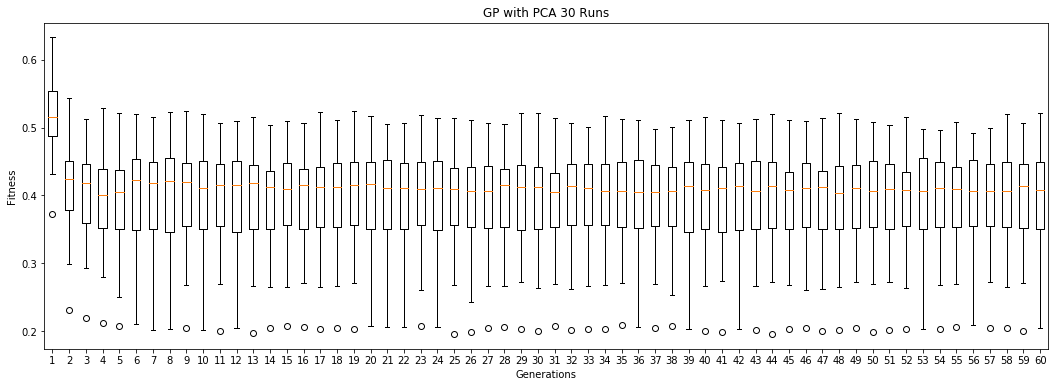

In [51]:
data = [[0.45794064423252584, 0.5021232750852646, 0.5563543780259, 0.3730583209211044, 0.5133467629748923, 0.4944313461970076, 0.504986105070227, 0.5802009012557402, 0.540551932707809, 0.473866824807982, 0.5686157656625537, 0.4646747306984132, 0.5186943775953717, 0.5483166335151233, 0.4322073492100505, 0.5119171225476336, 0.5964731341003119, 0.6007491493841699, 0.4931682452339451, 0.5785553983162074, 0.4440402913875815, 0.5619885382004106, 0.5262644831022868, 0.5488243687385345, 0.632892863965192, 0.5090154495584942, 0.43553966413240286, 0.4852087727571575, 0.5252977591622431, 0.5348383985272106], [0.37893692918293836, 0.47370022586284855, 0.38383636346869604, 0.23092293596675517, 0.43176426674757856, 0.4089723043886501, 0.46913033396672615, 0.44306688332957767, 0.449994053587634, 0.30653050649226293, 0.411653834712729, 0.29930979181666983, 0.3798760158794738, 0.5430671586467825, 0.31094203947483695, 0.43784169230625947, 0.4482067707511439, 0.45059936318406746, 0.36461673719987114, 0.4735216345176084, 0.3213424850828784, 0.44910746797981177, 0.4178502825402685, 0.49877673554590907, 0.5106082089675829, 0.4025730372268199, 0.3434587748268405, 0.44657956991387265, 0.40953752613440986, 0.5031159512045892], [0.37817371139549316, 0.45673635708670907, 0.3851389009509703, 0.21968683125521113, 0.3963689355817671, 0.416691872254525, 0.4638052814607009, 0.447744227977336, 0.42469466973305586, 0.2954518413185305, 0.41902673135390517, 0.2926336346008122, 0.3543497720964855, 0.5124327766186653, 0.302506779276473, 0.44184492898542777, 0.4500706922137995, 0.4334899655250641, 0.3428444791453243, 0.44222067372441703, 0.32098726658159493, 0.43493060349332463, 0.3973477968550488, 0.49193265585286977, 0.5124901626130396, 0.3763917239996786, 0.33241940023517536, 0.43216380282705424, 0.3893249748946798, 0.5029455729842977], [0.38028213399020167, 0.4679187004978921, 0.368566104974574, 0.21171312179941987, 0.38860515163043224, 0.3919889052682779, 0.47170134194468866, 0.4418413455845251, 0.4045105283331492, 0.27922170919268363, 0.4117536977552259, 0.291842643258976, 0.328391187027089, 0.511099668097145, 0.291618506747448, 0.43173008708307586, 0.44067083977534577, 0.42421252318140157, 0.34667556651830783, 0.42831043599383894, 0.3151256512193654, 0.4221225017838583, 0.39631135032319176, 0.4970544137198657, 0.5293528584204877, 0.37411588747310676, 0.32562193517430305, 0.4078253934622023, 0.37952656265341966, 0.48696254272654643], [0.3675312186046419, 0.45173083655763113, 0.3668944458350116, 0.20761908503796037, 0.4014815636477951, 0.3896429880596824, 0.47255544062626714, 0.4365927729074501, 0.4269539145238974, 0.25077821172782605, 0.40922262367135614, 0.2894661400108114, 0.34525908980828685, 0.5211204005911892, 0.29308208654526446, 0.4294866519156845, 0.4368908626366832, 0.4360707978802615, 0.34458577344748004, 0.42733718371392054, 0.31876262468114297, 0.43224384052453885, 0.40213076932960706, 0.48638112917172377, 0.5052556292786256, 0.3717263406886453, 0.3199874952694748, 0.4507706051654494, 0.3850383477908268, 0.4981775061515688], [0.3669262113467895, 0.46128989284270744, 0.3606245778222801, 0.20966516298990245, 0.4227480713304743, 0.38611438395596587, 0.456869982462906, 0.4455498831306358, 0.4246283846845721, 0.28624879536095493, 0.42263883355016685, 0.2924570411965356, 0.34182230307534855, 0.5196525229701151, 0.2973814469499599, 0.42793428092014585, 0.45888810067264685, 0.4458063896415795, 0.34799320492916264, 0.42719958469332825, 0.32088678375858176, 0.4352649038076494, 0.39520720091263767, 0.4947022724018133, 0.5062746288201934, 0.3499136435276509, 0.3265526439600623, 0.45866621216830455, 0.38106839206056947, 0.49832729345799537], [0.35647760357587505, 0.4441149966229836, 0.35843724902275126, 0.20086619713688034, 0.416556802770718, 0.38354805275976284, 0.4706891718006486, 0.4199691812361845, 0.42674731208077527, 0.2785978826859608, 0.4233088222948023, 0.2915111506641412, 0.3268020264770327, 0.5148986548726486, 0.29491646684002404, 0.4321242297505439, 0.45078693624722094, 0.44689988056072744, 0.3477761672198681, 0.42445934138048286, 0.32679677165728854, 0.45111934815693006, 0.4008535362401911, 0.4937065223314359, 0.4878504576039988, 0.3772958564232304, 0.3195734476869362, 0.4577459671875386, 0.40500588169516044, 0.4948572029943957], [0.36429674944117313, 0.45661495810750957, 0.36181915480774945, 0.20268372264540696, 0.42190216111450635, 0.38541691135036343, 0.46478992375318995, 0.4220837179281766, 0.419365610154997, 0.28452770774052694, 0.4254717274890495, 0.2726064010299797, 0.31700524753168435, 0.5195517732867146, 0.2864508821473835, 0.4202830758823318, 0.4589814895648986, 0.4510974535871235, 0.34110845458413813, 0.42283816803568886, 0.3179595555914953, 0.446482275546012, 0.3924620817938572, 0.47521675501505356, 0.5232437995581871, 0.37784148420249575, 0.3214656474361643, 0.4575640213283968, 0.42763689601890964, 0.4886285482915396], [0.36042988951460586, 0.45374281348499335, 0.3615046332753457, 0.2045288776934239, 0.41959059714912045, 0.37543711355840753, 0.46984504260987037, 0.4206910211576428, 0.4206306933682577, 0.28684361441694883, 0.4389074142950317, 0.2684530654940937, 0.32458192960840343, 0.5125012483369416, 0.2921786188256122, 0.4379263404183008, 0.4596942261280533, 0.4472669838770886, 0.3524566488912225, 0.4201663393262606, 0.3272111718046606, 0.4469425893045339, 0.39215318077370726, 0.4965296107752999, 0.5247164937681035, 0.3768513302886696, 0.32138035027550604, 0.44177208803099816, 0.4230205343107374, 0.4953810017834527], [0.36039735334058315, 0.4489367681949946, 0.35909567417470506, 0.20115401582725964, 0.40069152650684675, 0.3744699666684555, 0.46682367417982384, 0.42203332900502305, 0.40433622694187565, 0.2853045659487083, 0.43216329466081216, 0.26651633309407036, 0.32800739661874984, 0.5202949139532839, 0.28846018500216863, 0.4172873025597492, 0.45771996839476115, 0.45112620591755354, 0.3500394513219771, 0.42116310484378416, 0.32593726916072613, 0.4267286380927113, 0.3903931438398637, 0.4853714949960868, 0.5010758083893796, 0.3523378071387686, 0.3233548676156847, 0.4526133808061284, 0.4176341767298928, 0.4904604209402425], [0.36101621926307986, 0.44779123718674113, 0.36273777916818983, 0.19929898394302686, 0.415533227141212, 0.38127103505798854, 0.46420512934453706, 0.41879567219167313, 0.4220657992004239, 0.2841325259106523, 0.43404584785555084, 0.2687066095245138, 0.32950354715182933, 0.5074185921475659, 0.2860385199140529, 0.428586571533997, 0.46099249202699016, 0.4163882131417846, 0.3523478776159892, 0.42479825418258227, 0.32783340125822713, 0.4397525048706942, 0.39993830908455963, 0.4935982162989529, 0.49081026904160824, 0.36899909474648984, 0.3295989919894282, 0.44976830516325783, 0.41209898641016607, 0.4966256683084123], [0.3648060986714215, 0.4562956136157322, 0.3433478796913126, 0.2051551675805363, 0.41746794203070237, 0.37826871510474547, 0.4733070249464593, 0.41644260078152007, 0.4144925006843328, 0.28792357346358083, 0.43148828876601975, 0.26561283007992537, 0.32738774278436866, 0.5099382488056121, 0.28395281698808494, 0.4259822459527271, 0.46257293504256686, 0.43082552539179025, 0.3487993079089992, 0.42947797026795487, 0.3282392650046622, 0.43616689945461584, 0.39564343527877854, 0.49185240739033914, 0.49872451069862395, 0.3570539184007611, 0.34466797291044565, 0.4597100662470339, 0.4134700446359596, 0.4954654239747989], [0.3558134448469477, 0.44711887160543357, 0.3654461603356658, 0.19702809771443053, 0.4162759269582921, 0.3805235074962588, 0.4639197785252693, 0.419913370492014, 0.41878917799622795, 0.2818501180045587, 0.41928142699769105, 0.2658187616483064, 0.33453442360492597, 0.5149618675652641, 0.28487636194306704, 0.42931623033405053, 0.4702132188830923, 0.4357755955798513, 0.3484883715820261, 0.42647867333758105, 0.3272168797593847, 0.4370205530004504, 0.39341036258482837, 0.4919898297626087, 0.5004789544168388, 0.3613120829082503, 0.34672387903832264, 0.4554440400099614, 0.4087331354493503, 0.49107268580524166], [0.3538160766892009, 0.43604565985283805, 0.36282488791383144, 0.2039655348975682, 0.41775323302662803, 0.3678895952881052, 0.47302272632669645, 0.4274854060311849, 0.41268949999576787, 0.28485121625375637, 0.41014868570415847, 0.26502431980791263, 0.33757751469777264, 0.504011367654519, 0.28886600998226647, 0.4176079061335964, 0.46354210885218883, 0.4268947232928326, 0.3487165989237894, 0.42112000483014805, 0.31758349081540044, 0.43443189341574473, 0.39351579472687415, 0.4983254952527301, 0.4929370637958786, 0.3579722829342548, 0.3483881609674397, 0.449824189894867, 0.41279083946565925, 0.49329370028362757], [0.35773574484939386, 0.4580499325827823, 0.36300143105196014, 0.20699153826654795, 0.40963765295737425, 0.3740459677703681, 0.45442677940219306, 0.425876082727513, 0.4161176582921972, 0.28214624500406377, 0.4029895671553675, 0.2642714686459772, 0.33371424018882434, 0.5090057422165185, 0.28505347011334414, 0.42677034375191786, 0.46755738435615946, 0.4078336067573282, 0.3471443717921932, 0.4175046210507204, 0.32509456463490455, 0.436647176184402, 0.39948740684237016, 0.472870250637348, 0.49320110618324514, 0.3663125134980229, 0.3557154614474856, 0.4515663508453553, 0.412676235706529, 0.477781168228153], [0.35199260900278834, 0.44105869171137363, 0.3540417073932918, 0.2053774969571476, 0.41592227064627363, 0.38019513502432195, 0.4690495734950921, 0.42219596118123, 0.42246431883861935, 0.28574050569835296, 0.40174776799070455, 0.27048201536053995, 0.33024289951364877, 0.5060822685494828, 0.29461992823233407, 0.4164951232676657, 0.4755033536287034, 0.4136189006955694, 0.34715610120019375, 0.4201566275320524, 0.3199856883694736, 0.433354011538532, 0.3953557657627666, 0.4949867844409656, 0.4976400305570569, 0.37274515977020795, 0.35044197009190947, 0.44771933402020614, 0.41832600610402576, 0.4919171492565313], [0.3532749569848639, 0.45091263093551387, 0.36157827701469936, 0.20264914627220718, 0.4124283382943439, 0.37582760447122326, 0.47409063663912826, 0.42672061279987766, 0.42759882858419723, 0.2830448370040203, 0.4131010985106737, 0.2644886757224653, 0.324025939338411, 0.522658669926916, 0.29037749851192035, 0.42687633808494674, 0.4678176806438799, 0.41673150660355, 0.34524327244715886, 0.4167214249460929, 0.32406172085557117, 0.43664608714876785, 0.3945420189734121, 0.4827772488639313, 0.5092626059944381, 0.36986447170442377, 0.3545346799713745, 0.4427590151192074, 0.40950387772286867, 0.4949510428493678], [0.3556963474130898, 0.4524080086647959, 0.353289103600051, 0.2042596332186188, 0.4231885678003068, 0.3816074976906645, 0.47806930768078043, 0.42221498931644313, 0.4229697615083666, 0.2862507735251558, 0.4006190062459878, 0.26649876453785737, 0.332042616520877, 0.5118378161434874, 0.2902249307393978, 0.41442717775810206, 0.468108036829637, 0.41623962186826136, 0.3435628667306438, 0.42279752768391243, 0.3315076634663412, 0.43505592876508287, 0.39661044282205365, 0.4855478214634956, 0.4801537167375492, 0.3630421051617767, 0.3525041937752384, 0.4607449617196498, 0.40956450570436964, 0.48683061096764574], [0.35887422586548623, 0.4545577101055461, 0.3605551265800816, 0.2031997538260408, 0.4182078985496967, 0.37746483830931993, 0.46276572776877706, 0.420121363683646, 0.4000730324804942, 0.28427952478950497, 0.4136846588072813, 0.27039050103505125, 0.3261806066035408, 0.5251707898090159, 0.2935761589444796, 0.4213381820344787, 0.475397823473929, 0.4208215296986449, 0.3465079931705065, 0.4170098122069418, 0.3232242734998281, 0.43722247689400606, 0.3940110520591291, 0.4902793563838109, 0.48260161993510636, 0.36256435780525087, 0.3545165446725336, 0.4536035367551148, 0.4168696532150647, 0.4896278696577505], [0.3573554785176303, 0.46188559435334536, 0.35787173100080544, 0.20778683067363057, 0.4196059022130658, 0.3723612872778098, 0.47529097098297685, 0.421789163526774, 0.42054009118449054, 0.28520427059356523, 0.4134804660791869, 0.27317657220414054, 0.31912854494618187, 0.5173742455553524, 0.29357453326610616, 0.4206293550883372, 0.4718797324743002, 0.42214081153242494, 0.3484878636331063, 0.41926295119944795, 0.32886958120526183, 0.43893248614205366, 0.4012918020288074, 0.46505431645848855, 0.49650185526555196, 0.3504623403273903, 0.3528434017770124, 0.45183194953601447, 0.4059416301227908, 0.49665975885666014], [0.3593082934443462, 0.4600054036454366, 0.3533501149518018, 0.2055265069301047, 0.4170813395993413, 0.37316728067375265, 0.47761913028618763, 0.41260295132530667, 0.42553551389090744, 0.28452427736923686, 0.40997041893407066, 0.274403850977278, 0.30937158872497106, 0.5051912577297243, 0.28477036133463857, 0.3919869475289559, 0.4630111657659958, 0.4118349131059898, 0.34130991945846, 0.4215333887316834, 0.33084202238897975, 0.43561515097582104, 0.3933854593599887, 0.4747394517120557, 0.4883937503752956, 0.3624530904472999, 0.3490504797521921, 0.458253409869485, 0.41614348407713486, 0.4809824129287829], [0.3513172916608369, 0.4573363659181143, 0.3498306708741751, 0.2054950545980321, 0.4122949598846048, 0.37604254302780177, 0.4612194215430006, 0.4213928563579148, 0.413896153004391, 0.2912338056672233, 0.41128838711481075, 0.27138165595062297, 0.30724349518585775, 0.5063888003955499, 0.2935808293011617, 0.41832433360383486, 0.47220720699292246, 0.41123872783130166, 0.34762623764128997, 0.4164560449608846, 0.32503590829863793, 0.4345340796590862, 0.3958264698108217, 0.4738773948791189, 0.5012461582078919, 0.3633539734836045, 0.3578793179189034, 0.4524515164653446, 0.40959537135731067, 0.49288937306316477], [0.3559124155898823, 0.4576801422491943, 0.3604741421082635, 0.20778936168768886, 0.41285247569574374, 0.37598656695734817, 0.46622765504027003, 0.41802831113888317, 0.42238679467395956, 0.28821752721734417, 0.40554472986480516, 0.26099322557730853, 0.3150935846882326, 0.518147803163938, 0.28410878313851606, 0.3986847858517918, 0.47347160107278363, 0.4198803558175883, 0.3458429507855119, 0.4253942356250079, 0.32300663484558156, 0.4399088601293944, 0.3997599517665178, 0.4905895493164972, 0.5001301278771552, 0.3751733979692509, 0.35610954833768554, 0.45278150326473265, 0.4148364041558643, 0.47266195470488237], [0.35200910533728014, 0.46014874129989186, 0.34795844902809764, 0.2064869047897226, 0.4265941723418088, 0.3778878745931529, 0.4667290285241755, 0.42537318073546143, 0.4118226205029496, 0.282903234845218, 0.41399186159865664, 0.26965610665760775, 0.30830981820089004, 0.5139521420983391, 0.29006640030318176, 0.39692184182510454, 0.46873404868623303, 0.4112429576144561, 0.34641804628744616, 0.42845595199087116, 0.32685031768502393, 0.4335306846654512, 0.3946221944739947, 0.4889031048279243, 0.50294202893266, 0.36160288757737646, 0.36201023314557756, 0.4557284168172599, 0.4107799574142516, 0.49545964842629725], [0.35633616574065924, 0.45505402664886896, 0.3570982831284071, 0.19561571549450624, 0.41161134873330907, 0.3745870781812893, 0.45750768536156594, 0.4256532310992128, 0.4187253040036118, 0.2872052359771234, 0.40840511478162583, 0.2685770863560865, 0.31735185070840344, 0.5136478623410544, 0.2879238504646886, 0.4061776674113434, 0.46587919326573973, 0.42421230916802766, 0.3492158061335768, 0.42388364641177667, 0.33003057125249075, 0.4344789259853804, 0.39792923669169156, 0.49312649497086897, 0.502979662093022, 0.3684854536870174, 0.3561036102109783, 0.441612497414572, 0.4118422464100423, 0.4862711798326834], [0.3485880682281081, 0.4444650486422298, 0.3534118909615686, 0.19863408441302385, 0.41261983571835403, 0.3687349378756579, 0.4656882774765513, 0.4290670177135721, 0.42456553949138587, 0.28915099368530406, 0.4189016633366598, 0.24347254608895236, 0.3190870706908393, 0.5109611935273176, 0.28263499182839513, 0.40230285708558405, 0.4642111318846418, 0.41203164213488297, 0.35243771669701096, 0.4125945129154012, 0.33167251505510326, 0.4363080761730724, 0.39392066544559606, 0.47838674871173553, 0.4977864109133794, 0.3698360847908712, 0.3534866628481942, 0.4533411019561822, 0.4008393300778483, 0.4876707046345004], [0.3414449994363648, 0.4448663561254372, 0.3581771559901927, 0.20464538620772177, 0.42303759674721075, 0.37469409789823543, 0.46691428003853913, 0.426700276529218, 0.39888587899147143, 0.28345746761899565, 0.4136553382071078, 0.26641942095181753, 0.31448525901649294, 0.50674971623075, 0.29528734752153357, 0.3926984971358202, 0.4716969292218175, 0.4143124049461436, 0.3513586126313207, 0.4257186661467338, 0.32847290019666614, 0.4420170627653146, 0.38044271390663437, 0.4855188674942016, 0.5009152719073041, 0.3664004372838749, 0.3556964187647263, 0.4436736332356503, 0.41588760699195265, 0.4834779854499872], [0.35916432374625057, 0.4440478630329307, 0.3566781563784315, 0.20656582188725478, 0.4300522710611607, 0.37195263701500464, 0.4401087462037785, 0.42848181953555886, 0.4186700619274834, 0.28401531895888366, 0.4232809242727808, 0.26675367585614657, 0.31016078681838066, 0.5052006054660451, 0.29000797504032133, 0.4134117272366622, 0.46403861329789436, 0.4139830996980674, 0.35043190403754393, 0.42547915569907857, 0.3226609859910702, 0.4358082640674758, 0.39864990850472454, 0.48775682558692596, 0.5058678475984999, 0.36111756505251413, 0.35300085237051965, 0.4538498092629532, 0.41629232422222356, 0.49139641833375336], [0.35378109564421156, 0.453772332993371, 0.34491029112316407, 0.20231831524383848, 0.419998217107613, 0.3736235642742412, 0.4579061556251988, 0.4171403796775409, 0.412616796320543, 0.2831163580667016, 0.40605906239208567, 0.2724637716510878, 0.31216139288455325, 0.5209428985344766, 0.28849760697262805, 0.41212156590474863, 0.4637762745831079, 0.4162181045404124, 0.34786482033470095, 0.4168777202183932, 0.3287282897640981, 0.42071734859519117, 0.4017511440079551, 0.4782354203192191, 0.5031342860701171, 0.3662806932809629, 0.35466210433390655, 0.4537123492110716, 0.4183598088673757, 0.49270464369116856], [0.3555903395270007, 0.44347555073841866, 0.35082822849786005, 0.1993343508445838, 0.41417042176810415, 0.3843251385744715, 0.4556467403919701, 0.41997460199680947, 0.41628497101158884, 0.2895970432058639, 0.41233924901628083, 0.26307196099030505, 0.3147822488028633, 0.5209113512706942, 0.2883323979067296, 0.40367682820095135, 0.4669980893545218, 0.41903415123860766, 0.3440054354014788, 0.4163686773639696, 0.3253875330432173, 0.4353717107759514, 0.39856348659121027, 0.4892242772411912, 0.5013447805132532, 0.35860081712419645, 0.3496087908738802, 0.45005711390992365, 0.41352735009436375, 0.4920361479683856], [0.3569898597333726, 0.43304463965770845, 0.35318063464605065, 0.20673154349256784, 0.42464565729786025, 0.377743192056391, 0.47690640778229465, 0.4130188991366285, 0.4245119719999303, 0.28563513836548987, 0.4189319500335788, 0.26910757569993965, 0.3128929784262386, 0.5136520771450859, 0.2886698968509187, 0.4009400351513465, 0.46226624157594104, 0.4101730934975582, 0.3531513947373976, 0.4237412729664748, 0.3162028532269312, 0.4312194083956058, 0.3975221891152457, 0.49266665711479773, 0.49507134550333487, 0.3691295166191803, 0.35018551184864, 0.4592119342517037, 0.4003892710373108, 0.4777671655751049], [0.35574812716187454, 0.4564490359137748, 0.3573965587276795, 0.20196331900485961, 0.41623354279209884, 0.37537836482647147, 0.46589944400045374, 0.4310713116503899, 0.42537043952899556, 0.2859999164021037, 0.41455849613596896, 0.2618746490463643, 0.30847866546342506, 0.5062934386874178, 0.2905073704922844, 0.41200028150592655, 0.47754790851587003, 0.42286681931650694, 0.35359501635286456, 0.4202984953091715, 0.3301007812451636, 0.43349071903159453, 0.3928065552680949, 0.4920074547930679, 0.4961766133287721, 0.3717118600308949, 0.35740014258423786, 0.45090250330363724, 0.4130823624062639, 0.4892123389175719], [0.36456946204821666, 0.45578473994697105, 0.35635670321979745, 0.20355958195438936, 0.4104911445577868, 0.383115511957168, 0.47070950866260125, 0.4127300245381693, 0.41300348975785356, 0.2879807273199096, 0.41307050430792425, 0.26606263799402274, 0.3162340061890571, 0.5002702918366981, 0.2913473334804276, 0.4096574425269565, 0.4718300138960242, 0.4201281856570439, 0.33877843382631817, 0.4238146021753678, 0.3245424637034063, 0.4294372618740186, 0.40293435122788845, 0.4823715584397136, 0.4911545688336832, 0.3685417921751687, 0.3558651386230607, 0.4527004575759753, 0.41074274732484767, 0.4937749491223902], [0.35888490580088644, 0.449032490063124, 0.35555199336555127, 0.20229067787667104, 0.40819037235113065, 0.3830698401316918, 0.4626708033722855, 0.4233316126532324, 0.41781244208176943, 0.2831215176510665, 0.4067716712982665, 0.26845352208665, 0.31316001771992674, 0.5163933157232438, 0.29604568699473094, 0.40223134955289663, 0.46236757459402783, 0.4162879130400415, 0.34444530533918905, 0.42209269238148694, 0.3245072617976781, 0.4386320054618475, 0.3944645820853968, 0.48771417574452147, 0.4929414234693191, 0.37367934428485683, 0.35593606994653015, 0.4612599245870086, 0.4062050030655883, 0.4888239060290334], [0.35926783029421056, 0.4521788300598884, 0.35297840143431003, 0.20891200738987817, 0.41461575285504276, 0.37765040888254375, 0.4578905582740071, 0.41953886292648757, 0.42657461072035546, 0.2854247133475501, 0.4083691385139265, 0.27118921599899304, 0.3130079386705983, 0.513233338506742, 0.28174501058839574, 0.402939758668825, 0.4666225841427985, 0.41780432719645133, 0.3434989297363991, 0.41972925576116205, 0.3244489082372656, 0.43899195263091656, 0.40022489757392765, 0.48697332736004395, 0.4910109337630168, 0.35806488448106627, 0.35619946654071194, 0.4609136363310344, 0.4041202905633722, 0.48631805834732844], [0.3631906661718708, 0.459458839157368, 0.3531182900878762, 0.20535688201037686, 0.40901406037924865, 0.3798160858249136, 0.46720897083882784, 0.4294835639816032, 0.43289157952857527, 0.28681218106587153, 0.4154638848824665, 0.2723089363691053, 0.31565270860976996, 0.5110427113143557, 0.2882218381064804, 0.4005052254367174, 0.47137602954082714, 0.41810107768991883, 0.350210620072379, 0.41996177845291305, 0.31872648073803633, 0.42825618276338073, 0.39500914459908426, 0.49788001685839695, 0.48448652638395096, 0.3641230967753301, 0.3505184806117184, 0.4577212134976871, 0.39761354430700807, 0.49188380047971053], [0.35589845015483956, 0.4491504679986741, 0.3588266152307809, 0.20405748860291353, 0.41608401461668937, 0.37410426866839924, 0.47221020398917346, 0.4240970774956666, 0.42641185774482854, 0.28129345605769546, 0.40750260877764605, 0.26919000878535776, 0.31424614240865517, 0.4953354602682054, 0.29250243188967606, 0.40240954343518276, 0.47270410269955004, 0.41938989703514234, 0.35002376258174084, 0.4250333916791015, 0.3274282405881271, 0.4288986640265988, 0.3974668252887724, 0.4890521179315724, 0.49765496995829495, 0.368384014396579, 0.35360365540748895, 0.45376117141450184, 0.3938747461891871, 0.4873719145041046], [0.35812976735090246, 0.445488445825513, 0.3545375151671994, 0.2067812839444701, 0.4176225518770822, 0.3804035205921813, 0.47414587307477035, 0.41790635185934427, 0.41286285068781553, 0.28439129818982667, 0.41089846304564154, 0.25280698001781715, 0.3039398827134533, 0.49825988282398537, 0.2895496885728409, 0.40118613523681174, 0.46827420775484324, 0.41728273814763495, 0.35290068125949353, 0.42776614771963967, 0.32512623562505055, 0.4318787175578673, 0.39066794993288206, 0.4797372894162239, 0.5001177483057001, 0.36796837609270683, 0.3561351721242196, 0.45386948320940956, 0.3918896545515949, 0.4907086921072854], [0.34413013976791484, 0.4560229282426128, 0.35278807748893154, 0.20235339498799337, 0.4202748288187858, 0.37845468246784697, 0.45838478440314734, 0.4287010945063783, 0.41955968014341666, 0.2828043739494281, 0.4186017809360735, 0.2742936456403844, 0.31394085917695375, 0.5105404769175692, 0.2904108666731277, 0.41192789024731885, 0.4728478448735359, 0.41602173805426346, 0.33935164123447287, 0.4247411853938956, 0.31988134746001623, 0.42185590568716896, 0.4033840249171944, 0.47927610357609135, 0.5019639011439302, 0.36872077379157786, 0.35907270067440117, 0.45762784359607817, 0.38726221844312164, 0.48198065561342873], [0.3599832807710004, 0.4538263726843705, 0.35407168927389726, 0.20066809114640105, 0.4123490482384237, 0.3827180684057229, 0.47249986080121653, 0.419505358426876, 0.4227789840559156, 0.2844980125566717, 0.4126916503620095, 0.2657863196031292, 0.3168832017509631, 0.5159728744547188, 0.28952769384092397, 0.4032115317882467, 0.4716634895905458, 0.4250443154029116, 0.3475871509014539, 0.42045245529387865, 0.3259670387690171, 0.4350624769577956, 0.39772828534589827, 0.4768213357816041, 0.4976712849572515, 0.3710074762636588, 0.3482960297492922, 0.4508981641938824, 0.3811532670657447, 0.49108065761021064], [0.3484047076541409, 0.4572068703800557, 0.34616734630861434, 0.19897419954185125, 0.41534829384666055, 0.38046230586955887, 0.47284440213177836, 0.42660591044239193, 0.4137554143569209, 0.28303087560450496, 0.41450017296282615, 0.2739416516514577, 0.3181448531587544, 0.5113296999573171, 0.2855628593059954, 0.40831405198095677, 0.4693611342546478, 0.4215697602590442, 0.34081036077623716, 0.4260686090342426, 0.32059274111413266, 0.43264573441581977, 0.3997643093516628, 0.4887847763106041, 0.49749937809546707, 0.3673728474008546, 0.35695510899844285, 0.4446978024997524, 0.38268560149205827, 0.4881502123479475], [0.3548491782870156, 0.4520981361920215, 0.35428105243948643, 0.2032375379323158, 0.4171891210363324, 0.3741868812009645, 0.47278117011430437, 0.42454827828209757, 0.4262248879577189, 0.28804468645022, 0.4193867469955734, 0.2721827291723029, 0.30742261499445206, 0.5073970934976518, 0.2839328018718597, 0.4143212851784764, 0.4695569064753204, 0.4238937746336229, 0.34633400754147586, 0.4138130554563605, 0.3216876045193311, 0.4361097950334592, 0.3978555045916256, 0.47918137644983144, 0.4915885646793625, 0.3579989353723627, 0.3447599257667438, 0.45370415852888457, 0.3881536193000328, 0.4964792360922892], [0.35083560652066664, 0.4544395412638449, 0.3544860620186578, 0.20186550587101296, 0.41748102828767353, 0.3768546488731054, 0.46049868629087115, 0.4214542906717198, 0.4150669306866615, 0.2872248336072523, 0.40577612885221714, 0.26688764174346774, 0.31122461814558733, 0.513266325355137, 0.28136442420840996, 0.4082022491954486, 0.4703732675597629, 0.40581172495740064, 0.3499424936156147, 0.4173859907903323, 0.3256294151480079, 0.43765929923008756, 0.39563652393391285, 0.4917465434376481, 0.49428036348871157, 0.36306592238117896, 0.3512457281673094, 0.45977086652200316, 0.38274547781109575, 0.4896123634966154], [0.3538177035671222, 0.4572875258571034, 0.3512777962154172, 0.19587332858506906, 0.41570849515634595, 0.3775934756274246, 0.46491465738045396, 0.43293789412074085, 0.42192375780407965, 0.28655317963536514, 0.4132642647732061, 0.2728758913313256, 0.3154726681485857, 0.5203348995650727, 0.2937860382500358, 0.41428130523031476, 0.47442443830326037, 0.413565565764756, 0.3392645054899268, 0.42004821818687854, 0.3258713911868054, 0.4271280781759425, 0.38947041302472696, 0.48529930696201196, 0.4951699111530307, 0.36934781984976545, 0.3562097850079489, 0.45463991879962995, 0.380859280209044, 0.48510500259700895], [0.35626010133658864, 0.43173373245898067, 0.349990186105371, 0.2029850135067247, 0.4190783413734457, 0.3719153897728471, 0.4641329042857027, 0.4230375643052798, 0.4264032570543371, 0.2852823511588954, 0.41626104449965123, 0.2671183330804989, 0.3192795040367085, 0.5106330525481866, 0.29102968940562296, 0.40302425110101264, 0.47260012315836564, 0.41686931498100044, 0.3539936472002947, 0.414133793946517, 0.3181882410882058, 0.4362179765166655, 0.39854600197194223, 0.49796658722452625, 0.4929427712456069, 0.3654981148393971, 0.34969368303811166, 0.4517671046214983, 0.3861403519087361, 0.49868982324872146], [0.3609336636015036, 0.45359436517546387, 0.3512264339798517, 0.20394486319427507, 0.41881695961358784, 0.38003091949049156, 0.4654412810052451, 0.41873210671372796, 0.42270384282476503, 0.2870379091528999, 0.41650530172774425, 0.2609063645778231, 0.30711971909832175, 0.5098518361217996, 0.29050281563359315, 0.40588917859902185, 0.46328967185589814, 0.4144313391386738, 0.3483111861096695, 0.41988418081971896, 0.32913511294891623, 0.4325919493873844, 0.39029716709178897, 0.48792184924964094, 0.49549483987246784, 0.3653194089435039, 0.3571805427878078, 0.45431320409967857, 0.38466194579278645, 0.49418721470210014], [0.3524007949198154, 0.43771230702814357, 0.3488530652590335, 0.20002135096666718, 0.4170254650212958, 0.37905523055310114, 0.47205558832747313, 0.4290007418456743, 0.42367768634463626, 0.28172472890397454, 0.4075743324058776, 0.2622951348651377, 0.31373594967799895, 0.5144059926295486, 0.2894613695773481, 0.41961504143581874, 0.4717485612078845, 0.4197576786974918, 0.348739962999113, 0.4301839280629412, 0.3275024185559875, 0.4322680519574576, 0.3934460358685152, 0.48770801658580043, 0.48358609573604405, 0.36593201012931414, 0.35715608485578215, 0.45543346683714486, 0.3812557540808367, 0.4819985412872239], [0.35930914138317244, 0.44652035676972335, 0.3503385108346785, 0.2009933053762119, 0.4079780183073154, 0.3694521238586559, 0.4756966390775339, 0.39790583445785127, 0.42356861533186174, 0.27989630338068944, 0.4135548094052333, 0.26534623496349735, 0.3095284077579472, 0.5214079008061452, 0.29062660759821735, 0.41325511751835464, 0.4739252494484759, 0.4102295889797097, 0.3473289128742941, 0.42059266575328663, 0.32504150515874897, 0.4357840165615632, 0.3859949218861151, 0.4874098053660667, 0.4872645009578992, 0.3685255333289026, 0.35075738421544866, 0.4605169348770919, 0.3797355741307684, 0.4923917126007782], [0.3565706898193684, 0.44950555348115545, 0.3498979812766397, 0.20408790082396816, 0.4226564877224778, 0.3819940343978526, 0.4654470942279141, 0.4132818419113945, 0.4143116719740026, 0.2896520385287605, 0.41653335530704505, 0.27171701175410745, 0.31223256153045154, 0.5130121307754723, 0.2929287538307682, 0.4071888542036416, 0.47210606606642225, 0.4176660184598412, 0.3448815427022063, 0.4176471912009799, 0.3274728061288843, 0.42926529978194367, 0.39993991215069236, 0.4956373518469012, 0.49427836600085906, 0.36557069620179133, 0.359690342911271, 0.45529130743898466, 0.3769175745952843, 0.4945568647401358], [0.3588148575465464, 0.45620458502830924, 0.3535226640224291, 0.19866387218444778, 0.4189355340023257, 0.37918266407052165, 0.47158867250629266, 0.4318908880770308, 0.4280108252503465, 0.28209680795438324, 0.4101554323572316, 0.26982063011791235, 0.31062752291474927, 0.5086278118257511, 0.2897494116624734, 0.41415805649770826, 0.4718602398632341, 0.4033606970774501, 0.3392369488700482, 0.4222394626994415, 0.3315395659489078, 0.4360681011846403, 0.38721783832370693, 0.477519375654408, 0.48650761494857103, 0.3613972537259562, 0.3552900930158336, 0.45634336238549006, 0.37982754923520573, 0.4882474459078636], [0.34982504216566107, 0.4531191542653526, 0.3553632469728069, 0.20149999201918856, 0.4210924259905272, 0.3599423707347768, 0.45427043601141504, 0.41006740825269467, 0.4258562148677259, 0.27993225643242103, 0.4118239842331046, 0.2728282647829696, 0.3208158919664104, 0.5043063225434613, 0.29048650401877624, 0.40916026517487436, 0.47137384322265924, 0.41595045223116955, 0.3419605042244549, 0.4158451776338089, 0.3301507783616919, 0.4312721780294591, 0.39434248984341297, 0.4878019080848831, 0.49162485101882153, 0.3580133220366981, 0.35015764793357423, 0.4520282329125895, 0.3750607577978288, 0.48821421236530643], [0.3578352709178663, 0.4372399977622102, 0.35597244971562153, 0.20355167740087213, 0.41500722569899107, 0.37608957559371653, 0.46014625971675227, 0.4157994352000721, 0.4282199724657428, 0.282487569696766, 0.41423545937023337, 0.26331073982341957, 0.3114985728083049, 0.5162411339579793, 0.29004587798327996, 0.401526754205845, 0.4746008212533827, 0.4204922693422009, 0.3565771867107667, 0.4277190019982079, 0.3052239030528672, 0.4232850954807294, 0.394320163569843, 0.47751015454572354, 0.497026086230741, 0.3520647059767119, 0.35359756137284615, 0.4631528891084571, 0.3725357815126075, 0.49471768577245706], [0.3465752426546717, 0.46035841181129333, 0.35051714811988116, 0.20264906929251292, 0.4180234961225948, 0.3679513860060267, 0.46351333546068546, 0.41654485125664054, 0.42423565791207335, 0.28478773647921857, 0.41420932082133666, 0.26877911875673555, 0.31170331828619974, 0.4985458653141752, 0.2877213596651697, 0.3986291086739868, 0.4665585444808087, 0.41936467248995046, 0.35172633910788115, 0.4232773062900237, 0.32554283143072316, 0.44226426014953363, 0.3989762039462683, 0.49449190944226556, 0.4918192972555478, 0.3503521606592917, 0.3517813003148506, 0.4587335378018071, 0.37128624171190683, 0.4764814523326486], [0.3556722739083932, 0.45284171716865945, 0.35255619309534764, 0.20296720912055932, 0.42050052449636, 0.37347465376059014, 0.47151513468624723, 0.41534722012505904, 0.42211637042465644, 0.2870866029184924, 0.41113627623611537, 0.26718137162597017, 0.32099694299624987, 0.4961110783840638, 0.28652069117028417, 0.409280960398079, 0.474164873847192, 0.41116299280766283, 0.3539300210014059, 0.41832274333610253, 0.3245672747742096, 0.4372568398455234, 0.39702624455891844, 0.4858035581860098, 0.4926999835092926, 0.36103624590394395, 0.35085881523349916, 0.4576662464727427, 0.37461315395192635, 0.47841004665747355], [0.3597967173681789, 0.44405654359522956, 0.35297543447423474, 0.2053418731151405, 0.4126095446307383, 0.38273733785022196, 0.45153358826256385, 0.41704172411273244, 0.4214530658198863, 0.28475571130963473, 0.4186043164891739, 0.2688785716691865, 0.31706039896819466, 0.5078772874109828, 0.2897610888600689, 0.41142102813628234, 0.47378232469273657, 0.42054781379008793, 0.35557744987052947, 0.40824591370582075, 0.3288752323238359, 0.4365618109822499, 0.3994036487546095, 0.5008228405030756, 0.49368621854765027, 0.3644111727677658, 0.3525411087959981, 0.4499187576249471, 0.3765973988591945, 0.4929162185781651], [0.35358254751938273, 0.45663171548767767, 0.3573305752861983, 0.20945613504603103, 0.41655894162287554, 0.36887054437108524, 0.4623873200437825, 0.41525384165898305, 0.41448756931302194, 0.2860924568723582, 0.40902787865861084, 0.2712725410573284, 0.30288460937265543, 0.4913646824790369, 0.28932001937225876, 0.4051312642555096, 0.46947051773170434, 0.4149445937969696, 0.3563224678239487, 0.42909673699874, 0.31797611587476193, 0.4379805281661276, 0.4004461145904488, 0.4837729579128825, 0.48775039968351497, 0.35720038845958774, 0.3541642875364424, 0.45883866395203454, 0.3697749568069848, 0.48529879695930306], [0.353968262603223, 0.4505689972911599, 0.35422225271272034, 0.20505018284355817, 0.4191103811079109, 0.3718306878306674, 0.467824527521889, 0.41124534902586346, 0.42143904187010556, 0.2839255101235547, 0.41742975415580297, 0.27188860014175087, 0.31177499108484025, 0.49930847422065594, 0.28793611434505273, 0.3963813364656791, 0.46879825237440864, 0.41538994784008626, 0.3580134632890056, 0.41840162803318964, 0.3240074422873323, 0.43908881328918925, 0.4020601796346056, 0.4780464087956895, 0.4906007094742039, 0.36752633128952994, 0.35487558224402066, 0.44810148154721785, 0.37407357468827335, 0.48621185243017534], [0.3604416406906514, 0.4547880622265434, 0.35291264225404956, 0.20433428367572867, 0.4174724660743032, 0.3750871672518443, 0.45958286024325584, 0.433302588160774, 0.4313421514542564, 0.27743180119769667, 0.40597133865652996, 0.2653316914658956, 0.31323761742075823, 0.5204110661364828, 0.29272367437153074, 0.4064443765289877, 0.470325439886807, 0.4169705173365354, 0.3559305175942138, 0.4196521473927955, 0.3258919378547953, 0.4237190581726215, 0.39901284010988863, 0.48946415330025983, 0.48056056118227447, 0.3635699476896449, 0.35059376787046365, 0.4538593790348893, 0.37479634122908423, 0.47801061033992565], [0.35401037875037517, 0.4497506140323258, 0.34569315202789785, 0.19935396625911042, 0.41270433574029974, 0.37137399308583885, 0.4570942550777541, 0.42689078925114143, 0.4314081511948249, 0.2855580585060943, 0.4181936350518015, 0.27074524129858335, 0.30504170813811243, 0.507194856811052, 0.2891234371394624, 0.4141119575893551, 0.4724752327164557, 0.4159791425873646, 0.3510991231110259, 0.4222477510081746, 0.3289742997971069, 0.43572026606940667, 0.3920921587014096, 0.49214195260145027, 0.4924018057651254, 0.36353580087130233, 0.35737895845050494, 0.4599451121600282, 0.3784313757563505, 0.48922646890206917], [0.34968455698454826, 0.4555379734418712, 0.3490363733528933, 0.20507925035143962, 0.4181491181643818, 0.3689829468321777, 0.4632692808778199, 0.417299239208061, 0.4312139353143378, 0.28275655665935445, 0.4057837395964745, 0.27016818908654344, 0.3035675655364226, 0.5208294227219105, 0.2905188026378617, 0.41014074277263135, 0.4701907893780532, 0.4252998715562686, 0.35380445410724554, 0.42197730201265005, 0.33165902059770686, 0.43678352985267604, 0.39843486033044373, 0.4951488605152825, 0.505251740429692, 0.3704547096774182, 0.3537001972802159, 0.4524714193392763, 0.3763043412147581, 0.4913325433985944]]
fig7, ax7 = plt.subplots(figsize=(18, 6))
ax7.set_title('GP with PCA 30 Runs')
plt.ylabel('Fitness')
plt.xlabel('Generations')
ax7.boxplot(data)
plt.show()